
## Delta GPTs - (Train on 100, 200, 300 and predict the next 20)

* Delta: SI differences
* compare 100 to 200 to 300
* Written to run on GPU
* Long train so best run on GPU


In [1]:

##!pip install xgboost
## !pip install matplotlib
## !pip install scikit-learn
## !pip install einops


In [2]:

import pandas as pd
import numpy as np


In [3]:

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [4]:

## import xgboost as xgb
## from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb


In [5]:


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import torch
import pandas as pd
import sklearn
import random



In [6]:

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score



## Univariate permutation example


In [7]:

from einops import rearrange
from math import sqrt, log


In [8]:

patch_size = 10
stride     = 4

x_enc = torch.rand( 8, 40, 24)
print( x_enc.shape )

B, L, M = x_enc.shape
print(B)
print(L)
print(M)

x_enc = rearrange(x_enc, 'b l m -> b m l')
print( x_enc.shape )

x_enc = x_enc.unfold(dimension=-1, size=patch_size, step=stride)
print( x_enc.shape )

x_enc = rearrange(x_enc, 'b m n p -> (b m) n p')
x_enc.shape


torch.Size([8, 40, 24])
8
40
24
torch.Size([8, 24, 40])
torch.Size([8, 24, 8, 10])


torch.Size([192, 8, 10])


## Moving Avg example


In [9]:

'''

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x

'''


'\n\nclass moving_avg(nn.Module):\n\n    def __init__(self, x):\n        \n        super().__init__()\n        \n        self.kernel_size = x.shape[2]\n        self.stride      = 1\n        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)\n\n    def forward(self, x):\n        \n\n        x = self.avg( x )         ## x.permute(0, 2, 1))\n        \n        ## x = x.permute(0, 2, 1)\n        \n        return x\n\n'

In [10]:

'''

x_enc = torch.rand( 8, 40, 5)

print( x_enc.shape )

obj_mov_avg = moving_avg( x_enc  )

res = obj_mov_avg( x_enc )

print( x_enc[1, 2, :])

ans = x_enc - res

print( ans[1, 2, :])

print( ans.shape )

'''



'\n\nx_enc = torch.rand( 8, 40, 5)\n\nprint( x_enc.shape )\n\nobj_mov_avg = moving_avg( x_enc  )\n\nres = obj_mov_avg( x_enc )\n\nprint( x_enc[1, 2, :])\n\nans = x_enc - res\n\nprint( ans[1, 2, :])\n\nprint( ans.shape )\n\n'


## Read the data


In [11]:

for_RNN_data_CIVS = pd.read_csv('input/RNN_time_DELAYS_2000_PerCast_rcalix.csv')


In [12]:

for_RNN_data_CIVS


Unnamed: 0     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0              1  0.719500                4.242439          2161.425209   
1              2  0.710486                4.174343          2168.238915   
2              3  0.666106                4.126144          2167.779119   
3              4  0.675145                4.120736          2166.974740   
4              5  0.776831                4.120331          2166.384674   
...          ...       ...                     ...                  ...   
1378        1379  0.762500                4.204430          2169.361647   
1379        1380  0.646000                4.208539          2169.079601   
1380        1381  0.654667                4.212648          2168.797556   
1381        1382  0.591667                4.217784          2168.444999   
1382        1383  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  ...  SE_Uptake_f3  NW_Uptake_f3  \
0              0.354        0.16  ...    182.533770    148.126483   
1              0.313        0.83  ...    183.725050    148.161842   
2              0.360        0.10  ...    195.812061    147.562523   
3              0.319        0.34  ...    188.028883    147.807509   
4              0.335        0.28  ...    200.141261    149.014319   
...              ...         ...  ...           ...           ...   
1378           0.343        0.30  ...    185.900341    148.103530   
1379           0.324        0.30  ...    182.408576    148.106012   
1380           0.325        0.16  ...    181.684649    148.108493   
1381           0.335        0.26  ...    195.202191    148.111595   
1382           0.328        1.08  ...    220.149599    148.115317   

      SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       192.512412     37.369999    36.439999         9.86   
1       192.366046     35.540001    35.970001         9.03   
2       198.423474     34.849998    36.590000         9.13   
3       179.116839     34.009998    35.900002         8.82   
4       186.052137     34.380001    35.970001         8.73   
...            ...           ...          ...          ...   
1378    199.914193     35.900002    37.259998        10.04   
1379    193.501805     35.900002    37.259998        10.04   
1380    194.328694     35.580002    36.500000         9.30   
1381    215.606202     35.130001    37.470001        10.01   
1382    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...           ...                    ...   
1378                98.334297     18.209401              36.727897  

In [13]:

cols_list_DF = for_RNN_data_CIVS.columns.values.tolist()
cols_list_DF


['Unnamed: 0',
 'SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']

In [14]:

l_new = ['SI_f1',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [15]:

for_RNN_data_CIVS = for_RNN_data_CIVS[l_new]


In [16]:

for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  ...  SE_Uptake_f3  \
0              0.354        0.16            21.080431  ...    182.533770   
1              0.313        0.83            20.996415  ...    183.725050   
2              0.360        0.10            20.749627  ...    195.812061   
3              0.319        0.34            20.609259  ...    188.028883   
4              0.335        0.28            20.617383  ...    200.141261   
...              ...         ...                  ...  ...           ...   
1378           0.343        0.30            21.039583  ...    185.900341   
1379           0.324        0.30            21.043999  ...    182.408576   
1380           0.325        0.16            21.048415  ...    181.684649   
1381           0.335        0.26            21.053935  ...    195.202191   
1382           0.328        1.08            21.060559  ...    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.014319    186.052137     34.380001    35.970001         8.73   
...            ...           ...           ...          ...          ...   
1378    148.103530    199.914193     35.900002    37.259998        10.04   
1379    148.106012    193.501805     35.900002    37.259998        10.04   
1380    148.108493    194.328694     35.580002    36.500000         9.30   
1381    148.111595    215.606202     35.130001    37.470001        10.01   
1382    148.115317    250.937261     35.570000    36.970001         9.47   

      SNORT_VALVE_POSITION_f3  TOP_PRESS_f3  HOT_BLAST_PRESSURE_f3  \
0                   98.334297     18.532928              36.602600   
1                   98.334297     18.397217              36.882963   
2                   98.334297     18.393974              36.568884   
3                   98.334297     18.370316              36.839147   
4                   98.334297     18.395860              36.658018   
...                       ...    


## Plots


In [17]:

plt.rcParams["figure.figsize"] = [15, 5]


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

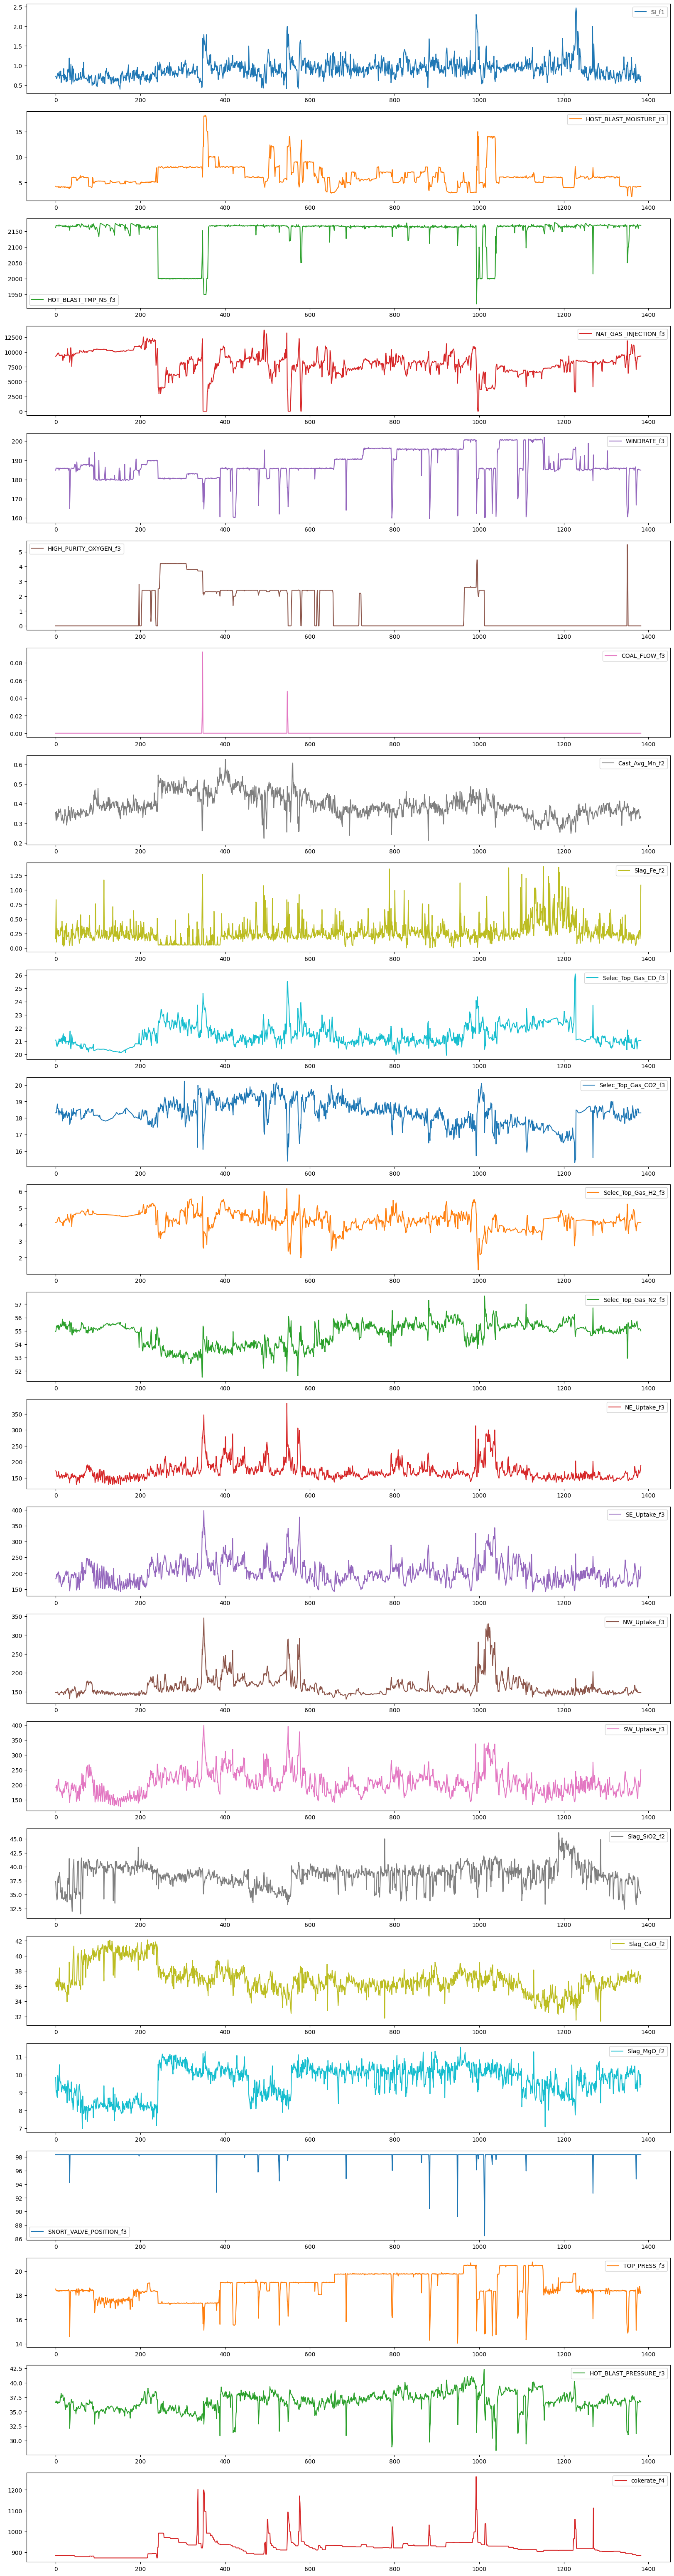

In [18]:

for_RNN_data_CIVS.plot( kind='line', subplots=True, figsize=(20,80),
        sharex=False, sharey=False, legend=True )


In [19]:

print(for_RNN_data_CIVS.shape)


(1383, 24)



## Parameters


In [20]:

pd.options.display.max_columns = None



## Standardize (Scaling)


In [21]:

def standardize_x_scales( data_gpt_pd ):


    data_gpt = torch.tensor(data_gpt_pd.values).float()
        
    epsilon = 0.0001

    print( data_gpt.shape)        
    
    x_means      = data_gpt .mean(0,  keepdim=True)
    x_deviations = data_gpt .std( 0,  keepdim=True) + epsilon

    ## x_train_tr_scaled = (x_train_tr - x_means) / x_deviations
    ## y_test_tr_scaled  = (y_test_tr  - y_means) / y_deviations
    
    return data_gpt, x_means, x_deviations


In [22]:

## x_means      = simple_x_train.mean(0, keepdim=True ) 
## x_deviations = simple_x_train.std( 0, keepdim=True) + epsilon



## Shift and create batches


In [23]:

def get_batch( data_gpt ):
    
    ix = torch.randint(   len(data_gpt) - block_size, (batch_size,)   )

    ## ix = [ int( tensor1.item() ) for tensor1 in ix ]
    ## print(ix.shape)
    ## print(ix)
    ## print(ix[1])
    ## print(  type(ix[1])  )
    ## print( len(data_gpt) - block_size )
    ## print(  block_size )
    ## print(  (batch_size,)  )
    
    x  = torch.stack(    [  data_gpt[   i   : i+block_size    ]   for i in ix ]    ) 
    y  = torch.stack(    [  data_gpt[   i+1 : i+1+block_size  ]   for i in ix ]    )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [24]:

'''

train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )

train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs

bt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )

bt_train_x.shape

bt_train_y.shape

x_means

'''


'\n\ntrain_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )\n\ntrain_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs\n\nbt_train_x, bt_train_y = get_batch( train_CIVS_tr_scaled )\n\nbt_train_x.shape\n\nbt_train_y.shape\n\nx_means\n\n'


## Estimate loss - No Training


In [25]:

@torch.no_grad()    ## for efficient processing
def estimate_loss( model, criterion ):
    
    out = {}
    model.eval()   ## set to no training
    
    for split in ['train', 'test']:
        losses = torch.zeros(eval_iters)
        for k in range( eval_iters ):
            X, Y = get_batch( split )
            logits  = model(X, Y)
            B, T, E  = logits.shape
            pred     = logits.view( B*T, E)
            y_train  = Y.view(B*T, E)
            loss =  criterion( pred, y_train )
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()  ## back to training

    return out



## NN Architectures


In [26]:

class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        
        self.key   = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.query = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]
        self.value = nn.Linear(n_embd, head_size, bias=False)  ## [512, 64]

        tril_def = torch.tril( torch.ones(block_size, block_size) )  ## [40, 40]
        
        self.register_buffer(
                  'tril', 
                  tril_def
               )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        
        B, T, E = x.shape   ## [batch_size, 40, 512]
        
        k = self.key(   x )            ## k = (B, T, 64)
        q = self.query( x )            ## q = (B, T, 64)

        E2 = 64     ## I think this is 64 and not 512
        ## (B, T, E) @ (B, E, T)  -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * E2 ** -0.5        
        
        wei = wei.masked_fill(
                      self.tril[:T, :T] == 0, 
                      float('-inf')
        )   
        
        ## (B, T, T)
        wei = F.softmax( wei, dim= -1 )         ## (B, T, T)
        wei = self.dropout(   wei   )
        
        ## perform weighted aggregation of values
        
        v   = self.value(  x  )   ## x = (B, 40, E)
        out = wei @ v             ## (B, T, T) @ (B, T, 64) -> (B, T, 64)
        
        return out
        


In [27]:

class FeedForward(nn.Module):

    def __init__(self, n_embd):         ## 512
        
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),      ## [512, 4*512]
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),      ## [4*512, 512]
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


In [28]:

class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):    ## (8, 64)
        super().__init__()
        self.heads = nn.ModuleList(  [ Head(head_size) for _ in range(num_heads) ] )
        self.proj  = nn.Linear(n_embd, n_embd)   ## 512, 512
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat(   [ h(x) for h in self.heads ], dim = -1   )
        out = self.proj(  out   )
        out = self.dropout(   out   )
        return out


In [29]:

class Block(nn.Module):
    
    def __init__(self, n_embd, n_head):     ## (512, 8)
        super().__init__()
        head_size = n_embd // n_head        ## 64
        self.sa   = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward( n_embd)    ## 512
        self.ln1  = nn.LayerNorm(n_embd)
        self.ln2  = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(     self.ln1(x)      )
        x = x + self.ffwd(   self.ln2(x)      )
        return x


In [30]:

class moving_avg(nn.Module):

    def __init__(self, x):
        
        super().__init__()
        
        self.kernel_size = x.shape[2]
        self.stride      = 1
        self.avg = nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)

    def forward(self, x):
        

        x = self.avg( x )         ## x.permute(0, 2, 1))
        
        ## x = x.permute(0, 2, 1)
        
        return x


In [31]:

class Time_Series_GPT(nn.Module):
    
    def __init__(self, seq_length, input_size, output_size):
        
        super().__init__()
        
        self.output_size= output_size
        self.seq_length = seq_length
        self.input_size = input_size

        
        ## self.token_embedding_table = nn.Embedding(vocab_size, n_embd)   ## [65, 512]
        self.pos_emb_table         = nn.Embedding(block_size, n_embd)     ## [block, 512]
        
        self.blocks = nn.Sequential(
                *[   Block(n_embd, n_head=n_head) for _ in range(n_layer)    ]
        )
        
        self.ln_f        = nn.LayerNorm(  n_embd    )        
        self.lm_ffw_head = nn.Linear(n_embd, 25)  ## [512, 65] # FFW Layer

        self.map_24_512 = nn.Linear(25, 512)  ## [24, 512] # rc remove
        self.map_act    = nn.ReLU()

        self.map_permute1 = nn.Linear( 512, 512 )
        self.map_permute2 = nn.Linear( 512, 512  )
        self.act_permute1 = nn.ReLU()
        

    def forward(self,  idx, targets):

        ## print( idx.shape      )
        ## print( targets.shape  )

        ######################

        obj_mov_avg = moving_avg(  idx  )
        res         = obj_mov_avg( idx )
        idx = idx - res

        #####################

        B = idx.shape[0]       ## 8
        T = idx.shape[1]       ## 20
        
        ## B, T = idx.shape     ## (Batch, 40)
        ## ids and targets are both (B, T) tensors of integers
        ## tok_emb = self.token_embedding_table(idx)  

        idx = self.map_24_512( idx )
        idx = self.map_act(    idx )

        tok_emb = idx       ## (8, 15, 512)
        pos_emb = self.pos_emb_table( torch.arange(T, device=device) )  

        ## print("blue")
        ## print(tok_emb.shape)
        ## print(pos_emb.shape)
        
        x = tok_emb + pos_emb    ## [B, T, E] or [64, 40, 512], now [8, 20, 24]

        ## self.map_24_512 = nn.Linear(24, 512)  ## [24, 512] # rc remove
        
        x = self.blocks(  x  )   ## (B, T, E)   
        x = self.ln_f(    x  )   ## (B, T, E)   ## norm
        logits = self.lm_ffw_head(x)         ## [B, 40, 65] 
        
        return logits
        
        
    def generate(self, idx, max_new_tokens):    ## idx is (B, T)
        for _ in range(max_new_tokens):
            ## crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:, :]
            print(idx_cond.shape)
            logits = self(idx_cond, 0 )    ## ## get preds
            logits = logits[:, -1, :]    ## focus on last one (B, E)
            logits = logits.unsqueeze(0)
            print(logits.shape)
            ## probs = F.softmax(logits, dim= -1)    ## (B, E) get probs
            ## idx_next = torch.multinomial(probs, num_samples=1)     ## (B, 1) selected
            idx = torch.cat(  (idx, logits), dim=1  )   ## (B, T+1) append sample to running sequence
            print(idx.shape)
        return idx
            


In [32]:

def train_model_GPT( train_CIVS_2 ):
 
    
    model  = Time_Series_GPT(block_size, 25, 25)
    model  = model.to( device )
    
    optimizer       = torch.optim.Adam(     model.parameters(), lr=learning_rate   )
    ## optimizer    = torch.optim.RMSprop(  model.parameters(), lr=learning_rate   )

    ## criterion       = nn.MSELoss()
    criterion       = nn.L1Loss()
    ## criterion_kl    = nn.KLDivLoss(reduction="batchmean")
    
    history = {'loss': [], 'test_loss': []}

    ## train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS )
    
    train_CIVS_tr, x_means, x_standard_devs = standardize_x_scales( train_CIVS_2 )

    train_CIVS_tr_scaled = ( train_CIVS_tr - x_means ) / x_standard_devs
        
    model.train()
    
    for batch_i, epoch in enumerate( range(max_iters) ):

        ## xb, yb = get_batch('train')
        xb, yb    = get_batch( train_CIVS_tr_scaled )

        ## rc

        logits   = model( xb, yb )

        B, T, E  = logits.shape
        
        pred           = logits.view( B*T, E)
        y_train        = yb.view(B*T, E)

        ## loss_cost = 0.0
        ## loss =  ( 1.0-loss_cost ) * criterion( pred, y_train ) + ( loss_cost ) * criterion( pred[:, 0], y_train[:, 0]  ) 

        #######################################################
        ## ind1 = random.randrange(0, y_train.shape[0] - 3)
        ## ind2 = ind1 + 3
        ## loss =  criterion( pred[ind1:ind2, 0], y_train[ind1:ind2, 0] )
        #######################################################

        loss =  criterion( pred, y_train )      ## seems better
        
        ## loss = criterion( pred[:, 0], y_train[:, 0]  ) 
        
        optimizer.zero_grad(set_to_none=True)           ## zero out
        loss.backward()
        optimizer.step()

        history['loss'].append(  loss.item()  )

        if batch_i % 500 == 0:
            print(batch_i, "train loss = ", loss.item() )

    
    return model, history, x_means, x_standard_devs



## Parameters


In [69]:

torch.manual_seed(256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size        = 15   ## 20     ## 4          ## 40      ## N tokens in sequence
batch_size        = 16 
max_iters         = 1000   ## 5000
eval_interval     = 500     
learning_rate     = 0.0001
eval_iters        = 300
vocab_size        = 88  ## 65

## every id for a given token is embedded to vector of this size

n_embd            = 512   ## 24        ## 512       ## 24 for time series, silicon is 0           
n_head            = 8         ## 8 attention heads
n_layer           = 6         ## 6 eoncoder layers
dropout           = 0.2



## Utility Functions


In [34]:

def GPT_get_batch_test( test_data ):
    
    ## x_time_series = torch.tensor(test_data.values).float()

    x_time_series = test_data

    print( x_time_series.shape )

    x  = torch.stack(   [   x_time_series[ 0 : -1    ]    ]    ) 
    y  = torch.stack(   [   x_time_series[ 1 :       ]    ]   )
    
    x, y = x.to(device), y.to(device)

    return x, y


In [35]:

def GPT_generate_inference(model, x_test, which_feature, string_feature, train_CIVS_2_a ):

    xb_test, yb_test = GPT_get_batch_test( x_test )
    
    print(xb_test.shape)
    print(yb_test.shape)

    input_test_x = xb_test[ :,  : 5 ]
    print("input to m.generate")
    print(input_test_x.shape)


    pred_20_seq = model.generate( input_test_x, 14 )

    print("shape of model generated output: ")
    print(pred_20_seq.shape)

    
    y_pred_gpt     = pred_20_seq.detach().cpu().numpy() 
    y_real_gpt     =     yb_test.detach().cpu().numpy() 

    print(index_to_slice)
    find_index = index_to_slice + 395
    SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index:find_index+19, 0]
    print(SI_data.shape)
    print(x_test.shape)
    
    
    print(y_pred_gpt.shape)
    print(y_real_gpt.shape)

    
    y_real_gpt = y_real_gpt.squeeze(0)
    y_pred_gpt = y_pred_gpt.squeeze(0)

    print( "unscaling" )

    print(y_pred_gpt.shape)
    print(y_real_gpt.shape)

    l_real = y_real_gpt[ :, 0]
    l_pred = y_pred_gpt[ :, 0]

    l_SI_data_real = SI_data

    si_mean         = x_means[0, 0].numpy()
    si_standard_dev = x_standard_devs[0, 0].numpy()

    print("these: ")
    print( x_means.shape )
    print( l_pred.shape )
    print( si_standard_dev.shape )
    print( si_mean.shape )
    print( si_standard_dev )
    print( si_mean)
    print( l_pred )
    print(  )
    

    ## y_descaled = y_scaled * self.y_deviations + self.y_means
    l_pred        = l_pred   * si_standard_dev   + si_mean
    l_real        = l_real   * si_standard_dev   + si_mean

    print( l_pred )
    
    print("unscale si end")


    eval_criterion = nn.MSELoss()

    mse_eval_bins = eval_criterion(
                          torch.FloatTensor( l_pred ), 
                          torch.FloatTensor( l_real )
    )

    print( l_pred  )
    print( l_real )

    print( l_pred.shape  )
    print( l_real.shape  )

    
    print( string_feature )
    print(f'Test MSE Loss: {mse_eval_bins.item():.4f}')
    print(l_real)
    print(l_pred)
    print(l_SI_data_real)
    print( "Testing R**2: ", r2_score(  l_real,  l_pred     )  )


    #######################################

    x = [ i for i in range(len(l_real)) ] 
    print(len(x))

    l_SI_data_pred = []
    www3 = SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[find_index - 1, 0]
    the_curr_val = www3 ##l_SI_data_real[0]  ### www3
    for i in range( len(l_pred) ):
        the_curr_val = the_curr_val + l_pred[i]
        l_SI_data_pred.append( the_curr_val )

    ## l_SI_data_real = np.roll(l_SI_data_real, -1)

    plt.scatter(x, l_real, label = "real", color='red') 
    plt.plot(   x, l_real, label = "real", color='red') 
    plt.plot(   x, l_SI_data_real, label = "real", color='red') 
 
    ##print( l_pred[1:].shape )
    ##print( l_pred[0].shape )
    ## l_pred  = np.concatenate( ( l_pred[1:, ], l_pred[0] ) )
    
    l_pred = np.roll(l_pred, -1)

    

    ## l_SI_data_pred = np.roll(l_SI_data_pred, 0)
    
    plt.scatter(x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_pred, label = "pred", color='blue') 
    plt.plot(   x, l_SI_data_pred, label = "pred", color='blue') 
    
    plt.legend() 
    plt.show()

    ##########################################

    train_plot = torch.tensor(train_CIVS_2_a.values).float().numpy()
    print( train_plot.shape )
    train_real_plot = train_plot[:, 0]
    ## l_real  = np.concatenate( ( train_real_plot[1: ], train_real_plot[:1] ) )
    l_real  = np.concatenate( ( train_real_plot, l_real ) )
    l_pred  = np.concatenate( ( train_real_plot, l_pred ) )
    ######################################

    x = [ i for i in range(len(l_real)) ] 
    print(len(x))

    x_delta = [ i for i in range(len(l_SI_data_real)) ] 
    print(len(x_delta))

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT Generate')
    ##ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ##ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].scatter(x, l_real, label = "real", color='red') 
    ax[0].plot(   x, l_real, label = "real", color='red') 
    ax[0].scatter(x, l_pred, label = "pred", color='blue') 
    ax[0].plot(   x, l_pred, label = "pred", color='blue') 
    ax[0].legend()
    
    ax[1].set_title(f"GPT")
    ax[1].scatter(x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].plot(   x_delta, l_SI_data_real, label = "real", color='red') 
    ax[1].scatter(x_delta, l_SI_data_pred, label = "pred", color='blue') 
    ax[1].plot(   x_delta, l_SI_data_pred, label = "pred", color='blue') 
    fig.tight_layout()
    ax[1].legend(); plt.show()


In [36]:

def function_train_rc(  train_data  ):
    train_CIVS_2 = train_data
    si_GPT, history_GPT, x_means, x_standard_devs = train_model_GPT( train_CIVS_2 )

    fig, ax = plt.subplots(2, 1) 
    ax[0].set_title(f'GPT  Train  Loss  per epoch')
    ax[0].plot(history_GPT['loss'],     'k--',   label='loss'      )
    ax[0].plot(history_GPT['test_loss'], 'k',    label='test_loss'  )
    ax[0].legend()
    ax[1].set_title(f"GPT")

    fig.tight_layout()
    ax[1].legend(); plt.show()

    return si_GPT, history_GPT, x_means, x_standard_devs 

    

In [37]:

def function_test_rc( train_data, test_CIVS, si_GPT, x_means, x_standard_devs):
    train_CIVS_2 = train_data
    
    print(  test_CIVS.shape )
    print( train_data.shape )
    ## print( train_data[ -5: ] )

    frames           = [ train_data[ -5: ], test_CIVS ]
    test_CIVS_concat = pd.concat( frames )
    print( test_CIVS_concat.shape )

    test_CIVS_tr = torch.tensor(test_CIVS_concat.values).float()
    test_CIVS_tr_scaled = ( test_CIVS_tr - x_means ) / x_standard_devs
    print(  test_CIVS_tr_scaled.shape )

    batch_x_test = test_CIVS_tr_scaled
    print( batch_x_test.shape )
    GPT_generate_inference(   si_GPT,  batch_x_test, 0 , "SI", train_CIVS_2 )


In [38]:

'''
SI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]
print(SI_data.shape)
SI_data
'''


'\nSI_data = SI_lookup_for_RNN_data_CIVS.to_numpy()[1040:1054, 0]\nprint(SI_data.shape)\nSI_data\n'


## The Data


In [39]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0


## Delta of SI


In [40]:

delta_for_RNN_data_CIVS      = for_RNN_data_CIVS.copy()
SI_lookup_for_RNN_data_CIVS  = for_RNN_data_CIVS.copy()


In [41]:

delta_for_RNN_data_CIVS 


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [42]:

delta_for_RNN_data_CIVS .insert(loc = 0,
                                column = 'delta_SI',
                                value = 0 )



In [43]:

for_RNN_data_CIVS


SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.719500                4.242439          2161.425209   
1     0.710486                4.174343          2168.238915   
2     0.666106                4.126144          2167.779119   
3     0.675145                4.120736          2166.974740   
4     0.776831                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.762500                4.204430          2169.361647   
1379  0.646000                4.208539          2169.079601   
1380  0.654667                4.212648          2168.797556   
1381  0.591667                4.217784          2168.444999   
1382  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       149.0

In [44]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0            0  0.719500                4.242439          2161.425209   
1            0  0.710486                4.174343          2168.238915   
2            0  0.666106                4.126144          2167.779119   
3            0  0.675145                4.120736          2166.974740   
4            0  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378         0  0.762500                4.204430          2169.361647   
1379         0  0.646000                4.208539          2169.079601   
1380         0  0.654667                4.212648          2168.797556   
1381         0  0.591667                4.217784          2168.444999   
1382         0  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [45]:

## merge_date_key = ''
## i_6000 = 0
## merge_date_key = list_dates_6000f[ i_6000 ]


    
for index, row in delta_for_RNN_data_CIVS.iterrows():

    if index > 1:
        ## if row["MM_Timestamp_f1"] <= merge_date_key and row['Timestamp_f1'] == 'abc':
        delta_for_RNN_data_CIVS.at[index,'delta_SI']= delta_for_RNN_data_CIVS.at[index,'SI_f1'] - delta_for_RNN_data_CIVS.at[index-1,'SI_f1'] 
        ## print(delta_for_RNN_data_CIVS.at[index,'SI_f1'])

        
## merge_date_key = list_dates_6000f[ i_6000 ] 
## MinByMin_137MB_data_CIVS.at[index, 'Timestamp_f1'] = merge_date_key
        
## if index  % 50000 == 0:
## print(index )
 


In [46]:

delta_for_RNN_data_CIVS


delta_SI     SI_f1  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000  0.719500                4.242439          2161.425209   
1     0.000000  0.710486                4.174343          2168.238915   
2    -0.044380  0.666106                4.126144          2167.779119   
3     0.009040  0.675145                4.120736          2166.974740   
4     0.101686  0.776831                4.120331          2166.384674   
...        ...       ...                     ...                  ...   
1378  0.109500  0.762500                4.204430          2169.361647   
1379 -0.116500  0.646000                4.208539          2169.079601   
1380  0.008667  0.654667                4.212648          2168.797556   
1381 -0.063000  0.591667                4.217784          2168.444999   
1382  0.133000  0.724667                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.84

In [47]:

l_delta = ['delta_SI',
 'HOST_BLAST_MOISTURE_f3',
 'HOT_BLAST_TMP_NS_f3',
 'NAT_GAS _INJECTION_f3',
 'WINDRATE_f3',
 'HIGH_PURITY_OXYGEN_f3',
 'COAL_FLOW_f3',
 'Cast_Avg_Mn_f2',
 'Slag_Fe_f2',
 'Selec_Top_Gas_CO_f3',
 'Selec_Top_Gas_CO2_f3',
 'Selec_Top_Gas_H2_f3',
 'Selec_Top_Gas_N2_f3',
 'NE_Uptake_f3',
 'SE_Uptake_f3',
 'NW_Uptake_f3',
 'SW_Uptake_f3',
 'Slag_SiO2_f2',
 'Slag_CaO_f2',
 'Slag_MgO_f2',
 'SNORT_VALVE_POSITION_f3',
 'TOP_PRESS_f3',
 'HOT_BLAST_PRESSURE_f3',
 'cokerate_f4']


In [48]:

delta_for_RNN_data_CIVS = delta_for_RNN_data_CIVS[ l_delta]


In [49]:

delta_for_RNN_data_CIVS


delta_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000                4.242439          2161.425209   
1     0.000000                4.174343          2168.238915   
2    -0.044380                4.126144          2167.779119   
3     0.009040                4.120736          2166.974740   
4     0.101686                4.120331          2166.384674   
...        ...                     ...                  ...   
1378  0.109500                4.204430          2169.361647   
1379 -0.116500                4.208539          2169.079601   
1380  0.008667                4.212648          2168.797556   
1381 -0.063000                4.217784          2168.444999   
1382  0.133000                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523    198.423474     34.849998    36.590000         9.13   
3       147.807509    179.116839     34.009998    35.900002         8.82   
4       14

In [50]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Add Moving average to data


In [51]:


delta_for_RNN_data_CIVS .insert(loc = 1,
                                column = 'mov_avg_SI',
                                value = 0 )



In [52]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000           0                4.242439          2161.425209   
1     0.000000           0                4.174343          2168.238915   
2    -0.044380           0                4.126144          2167.779119   
3     0.009040           0                4.120736          2166.974740   
4     0.101686           0                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500           0                4.204430          2169.361647   
1379 -0.116500           0                4.208539          2169.079601   
1380  0.008667           0                4.212648          2168.797556   
1381 -0.063000           0                4.217784          2168.444999   
1382  0.133000           0                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [53]:

delta_for_RNN_data_CIVS.shape[0]


1383

In [54]:


## for index, row in delta_for_RNN_data_CIVS.iterrows():

range_to_mean = 10

for i in range( 1, delta_for_RNN_data_CIVS.shape[0] ):
    index = delta_for_RNN_data_CIVS.shape[0] - i
    if index <= 10:
        ## range_to_mean = index -1
        break
    list_to_mean = []
    for j in range( range_to_mean ):
        list_to_mean.append(   delta_for_RNN_data_CIVS.at[ index-j , 'delta_SI' ]    )
    the_mean = np.array( list_to_mean )
    delta_for_RNN_data_CIVS.at[index,'mov_avg_SI']= np.mean(the_mean) 



In [55]:

delta_for_RNN_data_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
0     0.000000    0.000000                4.242439          2161.425209   
1     0.000000    0.000000                4.174343          2168.238915   
2    -0.044380    0.000000                4.126144          2167.779119   
3     0.009040    0.000000                4.120736          2166.974740   
4     0.101686    0.000000                4.120331          2166.384674   
...        ...         ...                     ...                  ...   
1378  0.109500    0.004444                4.204430          2169.361647   
1379 -0.116500    0.008900                4.208539          2169.079601   
1380  0.008667   -0.037618                4.212648          2168.797556   
1381 -0.063000   -0.014340                4.217784          2168.444999   
1382  0.133000    0.011422                4.223948          2167.967389   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
0               9306.840913   184.818611                    0.0           0.0   
1               9336.364456   185.993447                    0.0           0.0   
2               9419.200115   185.828474                    0.0           0.0   
3               9564.165802   185.924481                    0.0           0.0   
4               9648.247637   185.942943                    0.0           0.0   
...                     ...          ...                    ...           ...   
1378            9297.484543   185.046491                    0.0           0.0   
1379            9312.779010   185.053796                    0.0           0.0   
1380            9303.753420   185.007919                    0.0           0.0   
1381            9333.448101   184.942435                    0.0           0.0   
1382            9321.819731   184.863855                    0.0           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
0              0.354        0.16            21.080431             18.313322   
1              0.313        0.83            20.996415             18.311768   
2              0.360        0.10            20.749627             18.341701   
3              0.319        0.34            20.609259             18.644476   
4              0.335        0.28            20.617383             18.845791   
...              ...         ...                  ...                   ...   
1378           0.343        0.30            21.039583             18.308225   
1379           0.324        0.30            21.043999             18.308776   
1380           0.325        0.16            21.048415             18.309327   
1381           0.335        0.26            21.053935             18.310016   
1382           0.328        1.08            21.060559             18.310842   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
0                4.131228            54.940123    171.769513    182.533770   
1                4.133911            55.072779    170.595469    183.725050   
2                4.137632            55.375043    167.017421    195.812061   
3                4.142824            55.341884    154.214917    188.028883   
4                4.220690            55.284451    156.234542    200.141261   
...                   ...                  ...           ...           ...   
1378             4.129485            55.162782    167.619915    185.900341   
1379             4.129674            55.162767    164.706552    182.408576   
1380             4.129862            55.140373    166.903493    181.684649   
1381             4.130097            55.098014    175.524144    195.202191   
1382             4.130380            55.003376    189.407795    220.149599   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
0       148.126483    192.512412     37.369999    36.439999         9.86   
1       148.161842    192.366046     35.540001    35.970001         9.03   
2       147.562523

In [56]:

for_RNN_data_CIVS = delta_for_RNN_data_CIVS



## Pick slice randomly


In [57]:

training_chunk = 400


In [58]:

length_n  = int( for_RNN_data_CIVS.shape[0] )

length_n


1383


## Run 1


In [59]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice


606

In [60]:

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )


1383
606
1021


In [61]:

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]


In [62]:

sliced_chunk_CIVS


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
606  -0.107901   -0.003864                8.980173          2166.925325   
607  -0.137807   -0.036793                8.962835          2166.136036   
608   0.123308   -0.005385                9.025578          2164.750010   
609   0.000192   -0.000615                8.831140          2166.889564   
610   0.118745    0.010685                6.454687          2165.218024   
...        ...         ...                     ...                  ...   
1016  0.376000    0.088101                7.859131          2100.089142   
1017  0.091692    0.096475                7.966871          2099.188576   
1018 -0.404230    0.047033                9.188163          2099.896945   
1019 -0.120555    0.041197               12.078056          1999.916358   
1020  0.094577    0.017443               14.005765          1999.325320   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
606             7795.323908   185.661610               2.402476           0.0   
607             7738.553353   185.690046               2.399719           0.0   
608             7555.902381   185.819832               2.400910           0.0   
609             7593.676308   185.780103               2.399227           0.0   
610             8494.774775   185.743685               2.405526           0.0   
...                     ...          ...                    ...           ...   
1016            4022.444850   184.967634               0.000000           0.0   
1017            4002.076710   185.814254               0.000000           0.0   
1018            3499.403889   185.879025               0.000000           0.0   
1019            3500.681172   185.694078               0.000000           0.0   
1020            3498.358681   185.805792               0.000000           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
606            0.415        0.28            21.391049             19.435218   
607            0.396        0.33            21.484493             19.552049   
608            0.392        0.30            21.451909             19.592748   
609            0.356        0.21            21.734402             19.633404   
610            0.384        0.40            21.296211             19.093825   
...              ...         ...                  ...                   ...   
1016           0.410        0.51            21.905609             18.039307   
1017           0.456        0.23            21.771071             18.134629   
1018           0.477        0.89            22.097258             18.422419   
1019           0.455        0.38            21.784646             18.191825   
1020           0.429        0.29            22.011484             17.966430   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
606              4.159250            53.683360    166.804026    199.065378   
607              4.174441            53.413826    168.198629    190.569725   
608              4.267687            53.399942    167.867750    187.582370   
609              4.169273            53.087908    163.550438    175.925984   
610              4.022220            54.037191    160.755377    171.225157   
...                   ...                  ...           ...           ...   
1016             2.942853            56.054345    286.939403    294.747724   
1017             2.902128            56.278307    287.926421    294.857817   
1018             2.854332            55.736726    280.577235    301.902649   
1019             3.262800            55.614058    285.301594    303.004278   
1020             3.657950            55.188621    262.854794    289.608676   

      NW_Uptake_f3  SW_Uptake_f3  Slag_SiO2_f2  Slag_CaO_f2  Slag_MgO_f2  \
606     161.760950    200.574210     38.410000    36.009998         9.81   
607     160.633205    193.705685     40.130001    37.330002        10.66   
608     160.349881


## Train and test


In [63]:

n = block_size

print( n )


15


In [64]:

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]


In [65]:

print( train_CIVS.shape )
print( test_CIVS.shape )


(400, 25)
(15, 25)


In [66]:

test_CIVS 


delta_SI  mov_avg_SI  HOST_BLAST_MOISTURE_f3  HOT_BLAST_TMP_NS_f3  \
1006 -0.140681   -0.134477                5.023497          1999.860190   
1007  0.007946   -0.130666                5.020241          1999.751882   
1008  0.090195   -0.052264                5.016393          2094.832147   
1009 -0.062200   -0.077986                4.872952          2167.046784   
1010  0.332119   -0.058896                3.993186          2162.961403   
1011  0.162949    0.010027                4.118713          2162.832384   
1012 -0.127000    0.001610                4.809774          2171.979807   
1013 -0.245231   -0.031814                4.561482          2165.850701   
1014  0.217339    0.008471                4.103296          2163.164384   
1015  0.128892    0.036433                4.069937          2167.013859   
1016  0.376000    0.088101                7.859131          2100.089142   
1017  0.091692    0.096475                7.966871          2099.188576   
1018 -0.404230    0.047033                9.188163          2099.896945   
1019 -0.120555    0.041197               12.078056          1999.916358   
1020  0.094577    0.017443               14.005765          1999.325320   

      NAT_GAS _INJECTION_f3  WINDRATE_f3  HIGH_PURITY_OXYGEN_f3  COAL_FLOW_f3  \
1006            3687.850031   185.962066               2.396816           0.0   
1007            5382.011260   185.440501               2.400472           0.0   
1008            5549.320660   185.998522               2.399281           0.0   
1009            6080.197736   185.441527               2.398171           0.0   
1010            6663.597459   185.627360               2.401755           0.0   
1011            6625.182634   185.653706               2.400075           0.0   
1012            4712.056378   185.113299               2.401105           0.0   
1013            6273.672978   160.052506               0.000000           0.0   
1014            6620.507474   160.100632               0.000000           0.0   
1015            6619.518796   160.377925               0.000000           0.0   
1016            4022.444850   184.967634               0.000000           0.0   
1017            4002.076710   185.814254               0.000000           0.0   
1018            3499.403889   185.879025               0.000000           0.0   
1019            3500.681172   185.694078               0.000000           0.0   
1020            3498.358681   185.805792               0.000000           0.0   

      Cast_Avg_Mn_f2  Slag_Fe_f2  Selec_Top_Gas_CO_f3  Selec_Top_Gas_CO2_f3  \
1006           0.359        0.20            22.461350             20.094348   
1007           0.343        0.26            22.395392             19.498172   
1008           0.339        0.22            22.732615             19.267515   
1009           0.382        0.25            22.843924             19.121099   
1010           0.363        0.20            22.379667             19.007040   
1011           0.398        0.27            21.843675             19.541892   
1012           0.389        0.29            21.907236             19.381495   
1013           0.360        0.17            20.373118             17.110796   
1014           0.368        0.31            20.604640             18.162545   
1015           0.378        0.18            20.651743             18.355713   
1016           0.410        0.51            21.905609             18.039307   
1017           0.456        0.23            21.771071             18.134629   
1018           0.477        0.89            22.097258             18.422419   
1019           0.455        0.38            21.784646             18.191825   
1020           0.429        0.29            22.011484             17.966430   

      Selec_Top_Gas_H2_f3  Selec_Top_Gas_N2_f3  NE_Uptake_f3  SE_Uptake_f3  \
1006             2.288493            54.358775    201.159372    209.024513   
1007             2.758357            54.480890    206.064503    225.196027   
1008     

In [67]:

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


In [70]:

print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.8575862646102905
500 train loss =  0.15228480100631714


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


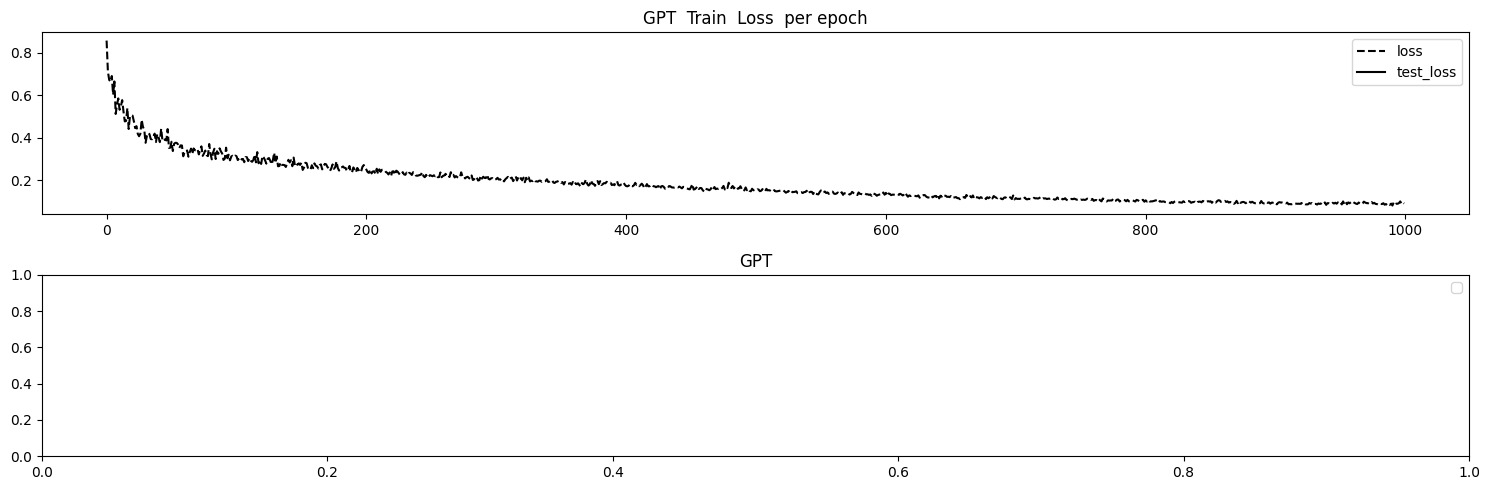

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

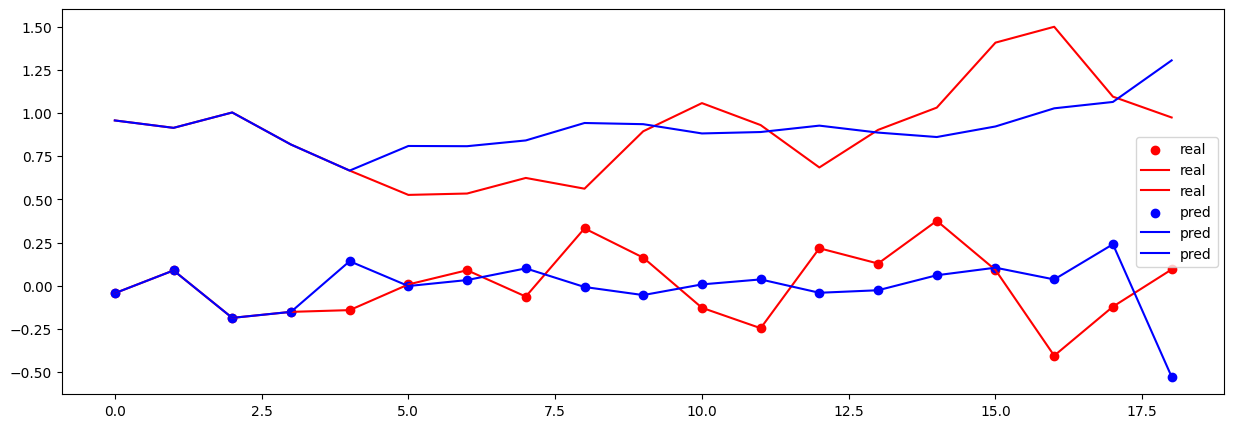

(100, 25)
119
19


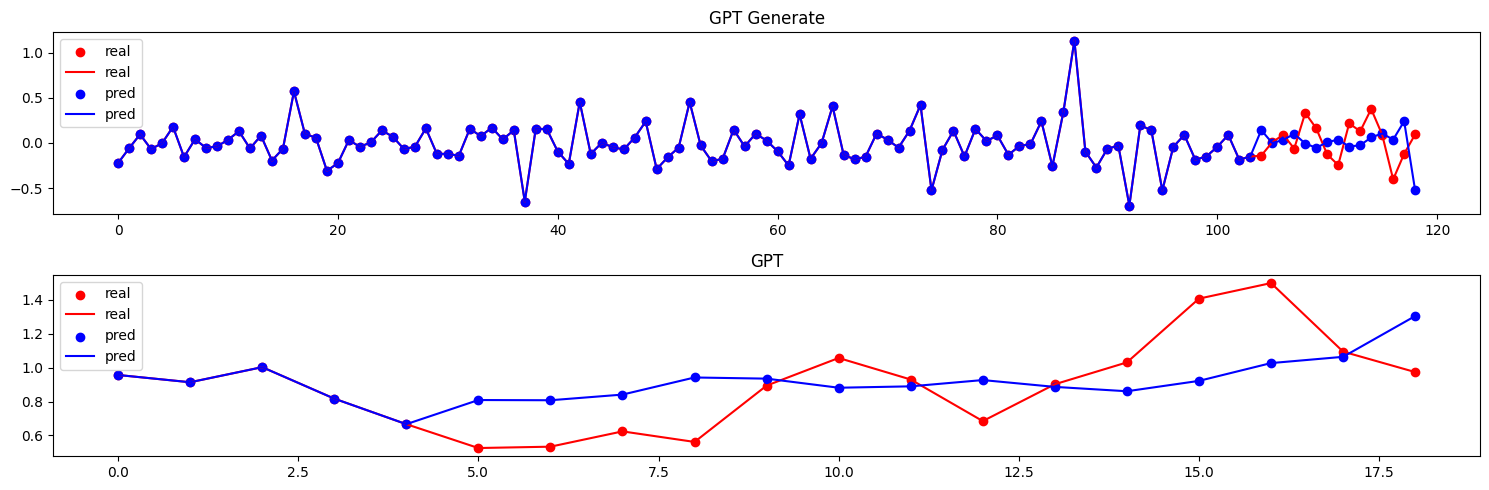

In [71]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([200, 25])
0 train loss =  0.728762686252594
500 train loss =  0.21438024938106537


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


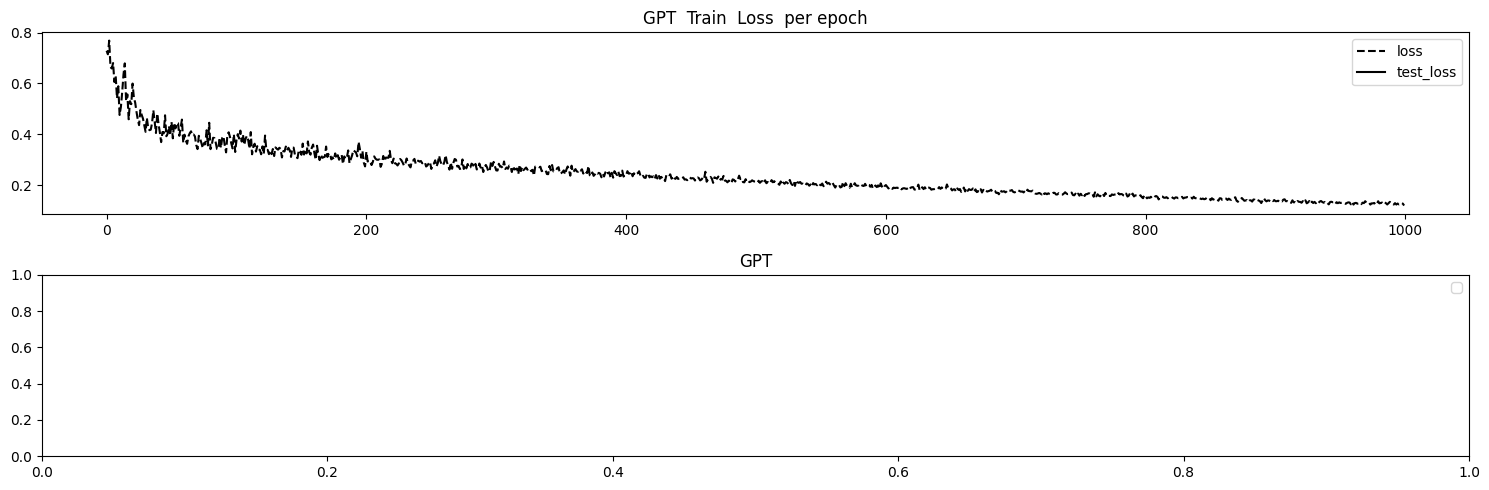

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

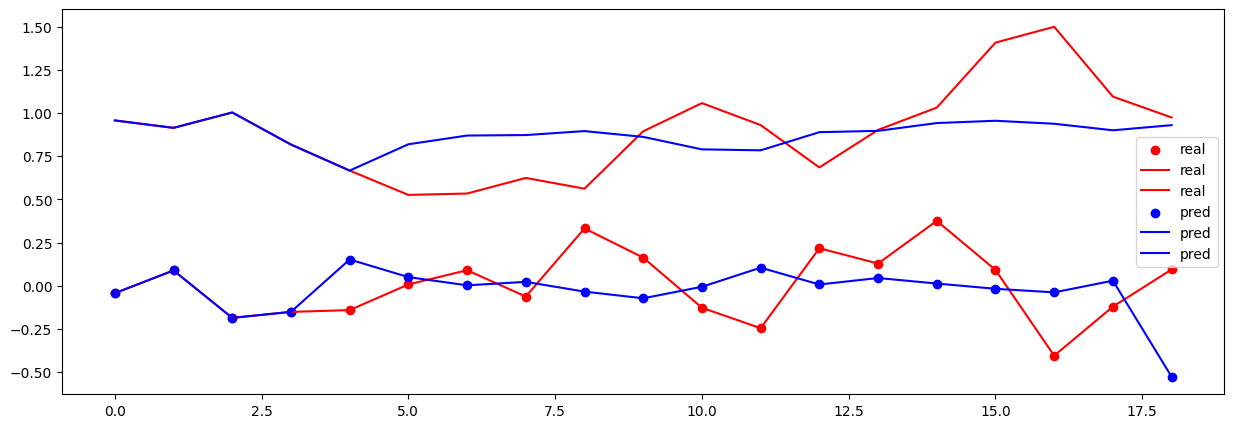

(200, 25)
219
19


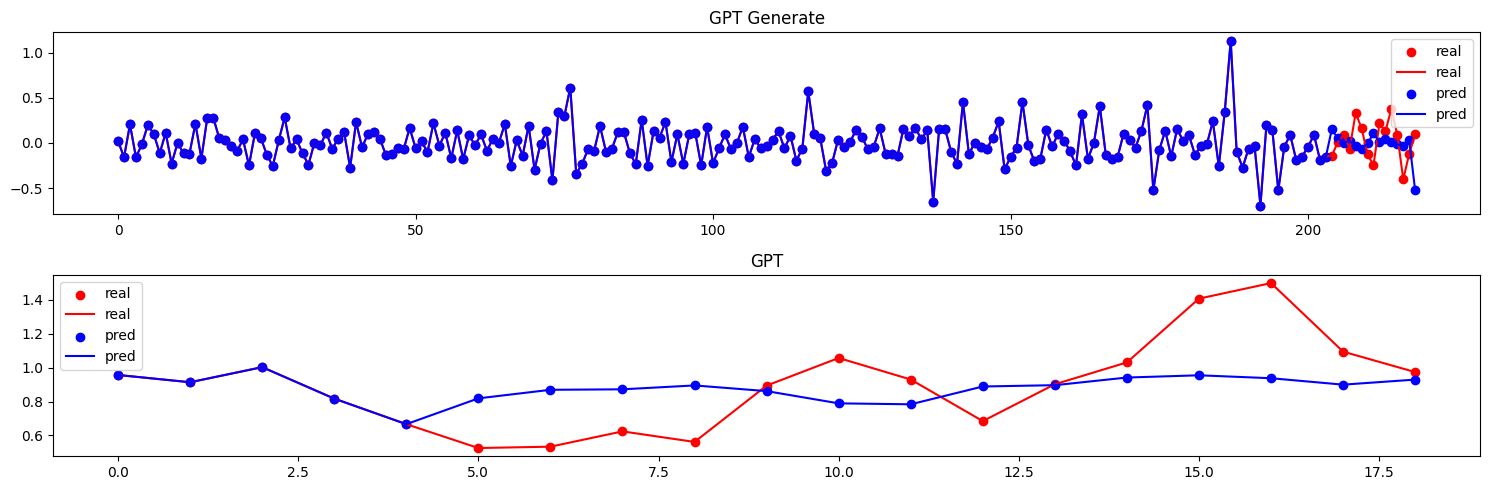

In [72]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

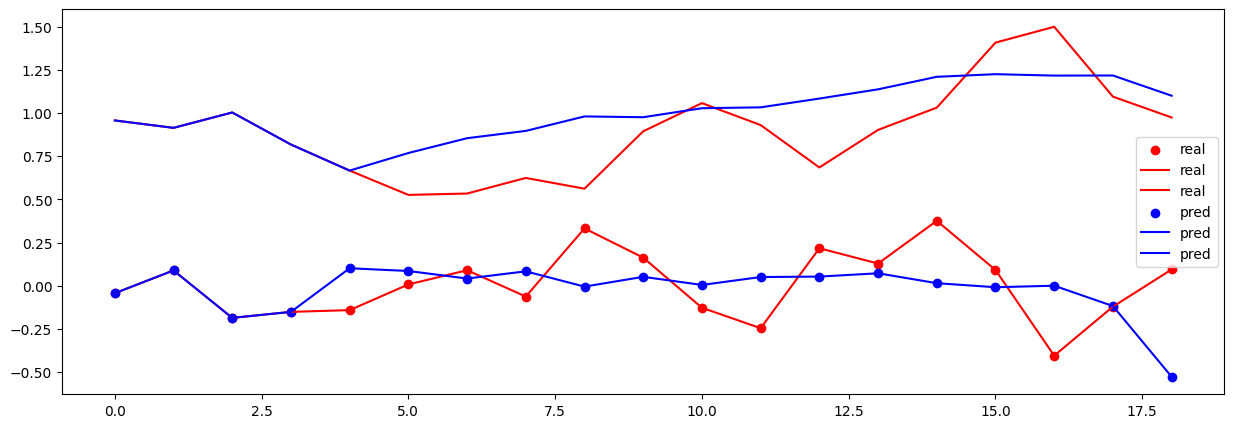

(200, 25)
219
19


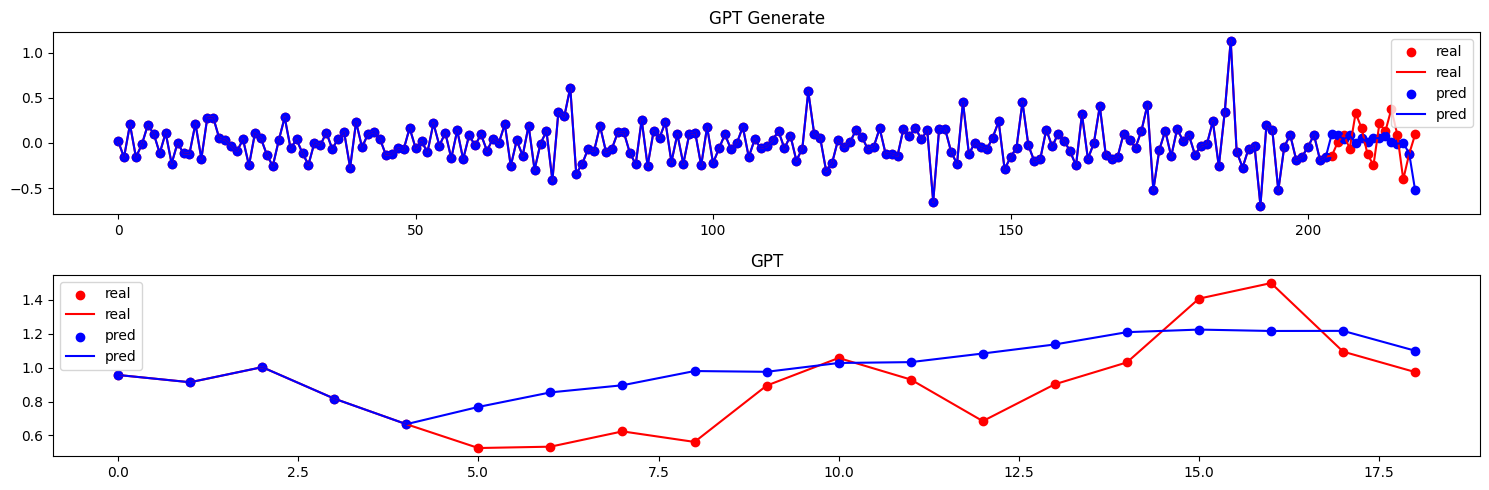

In [73]:

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([300, 25])
0 train loss =  0.8126365542411804
500 train loss =  0.2552092373371124


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


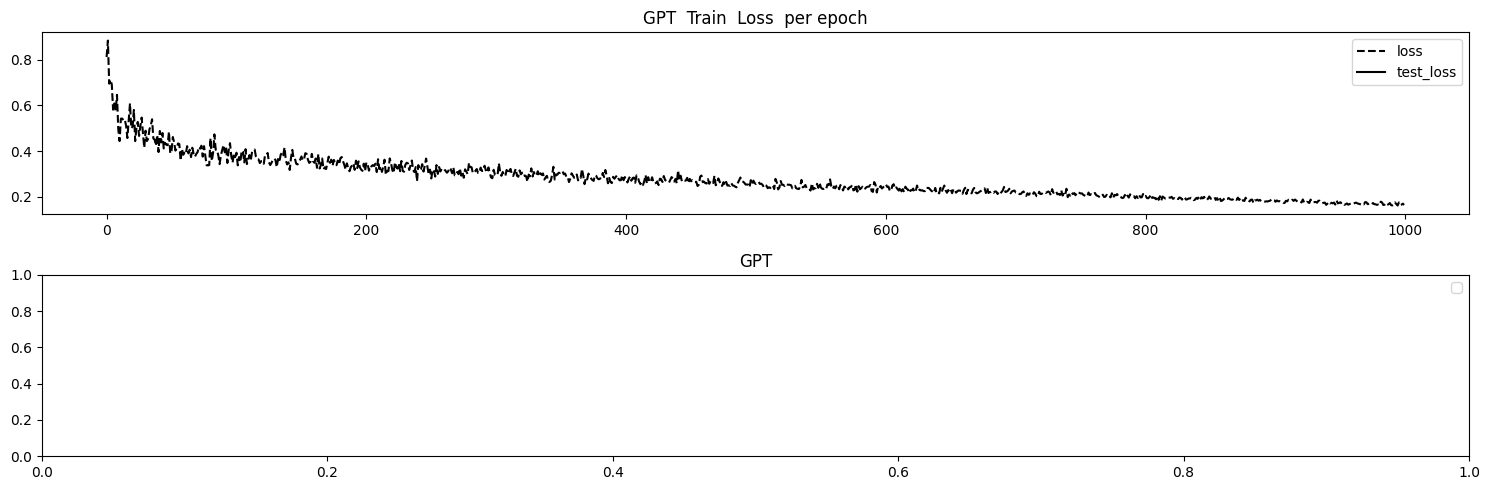

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

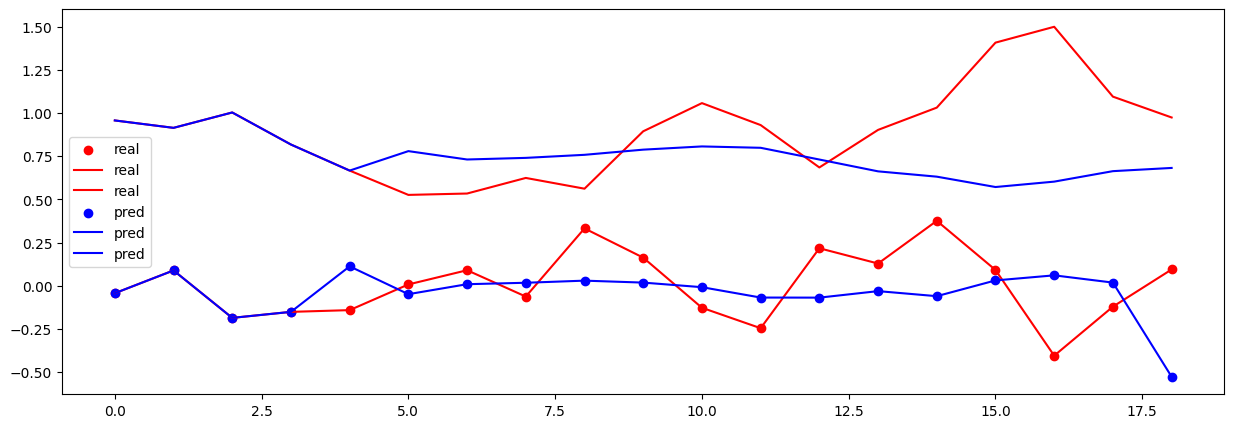

(300, 25)
319
19


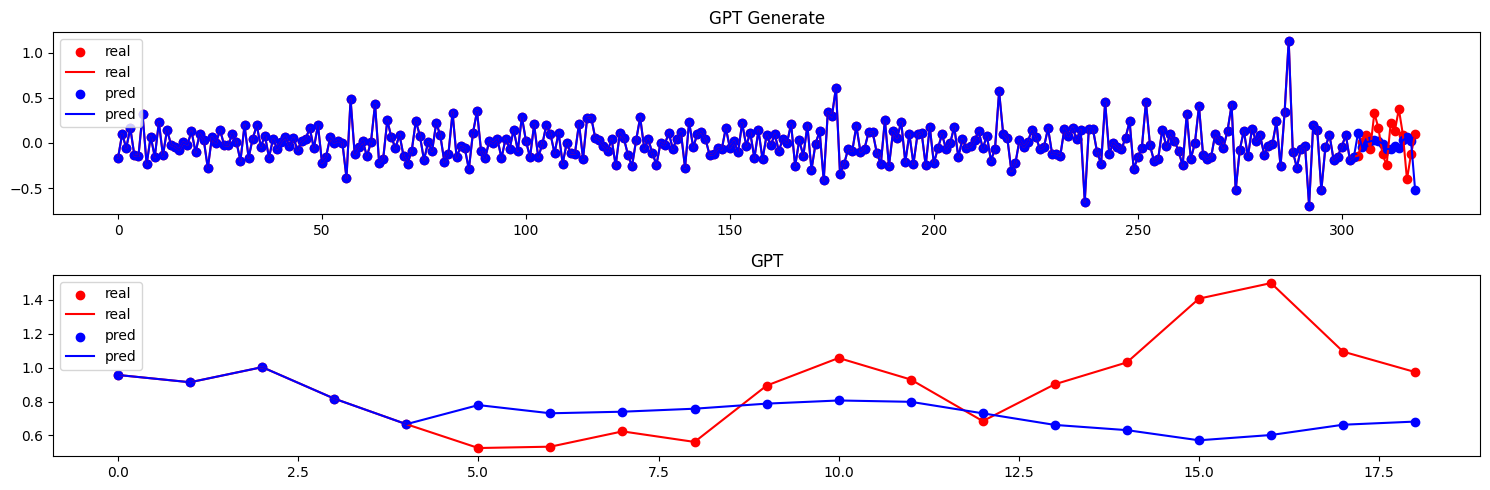

In [74]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([400, 25])
0 train loss =  0.9025065898895264
500 train loss =  0.2820555865764618


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


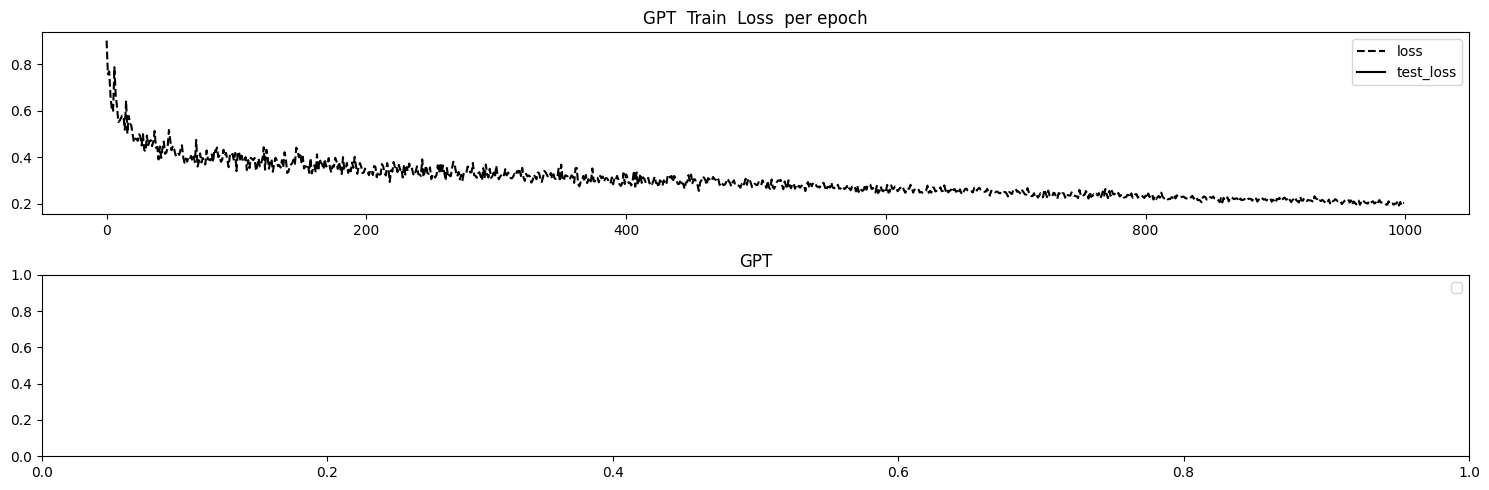

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

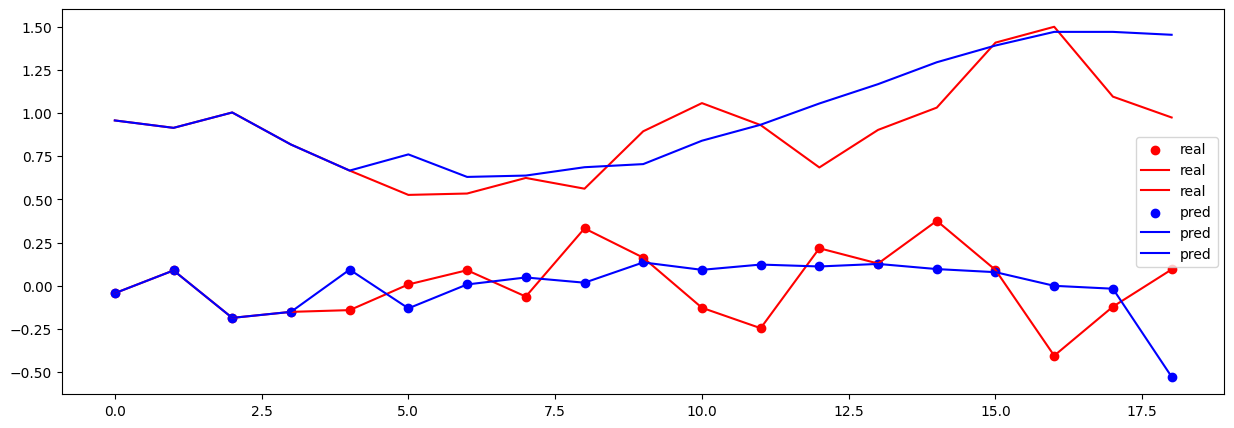

(400, 25)
419
19


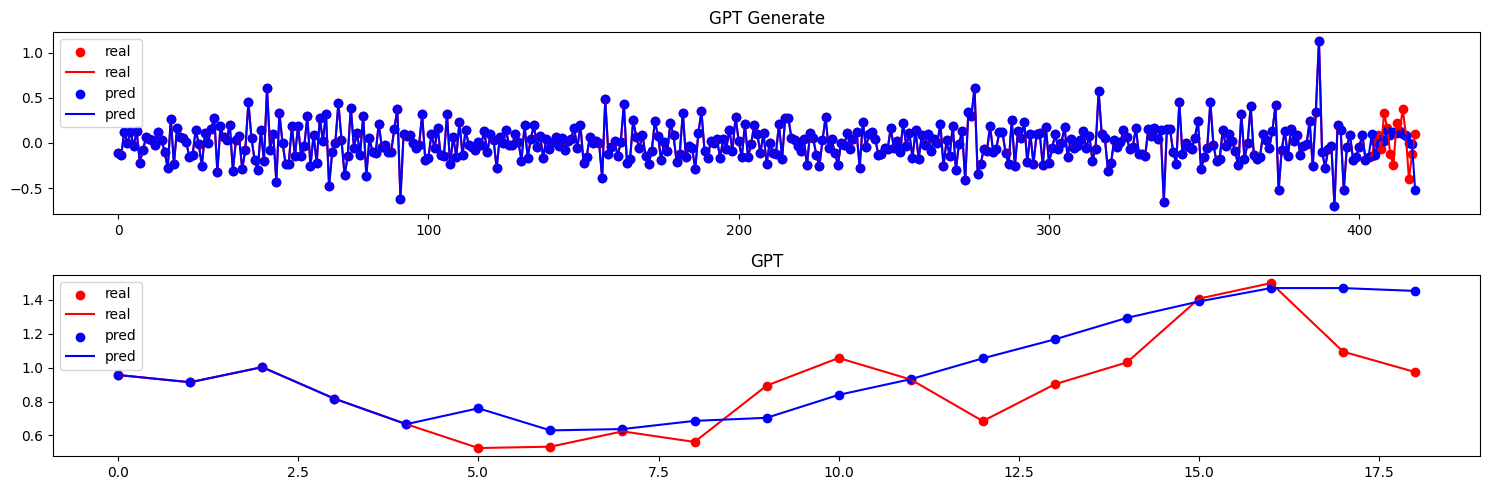

In [75]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 2


In [76]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ]  


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )





1383
429
844
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.724272608757019
500 train loss =  0.13244590163230896


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


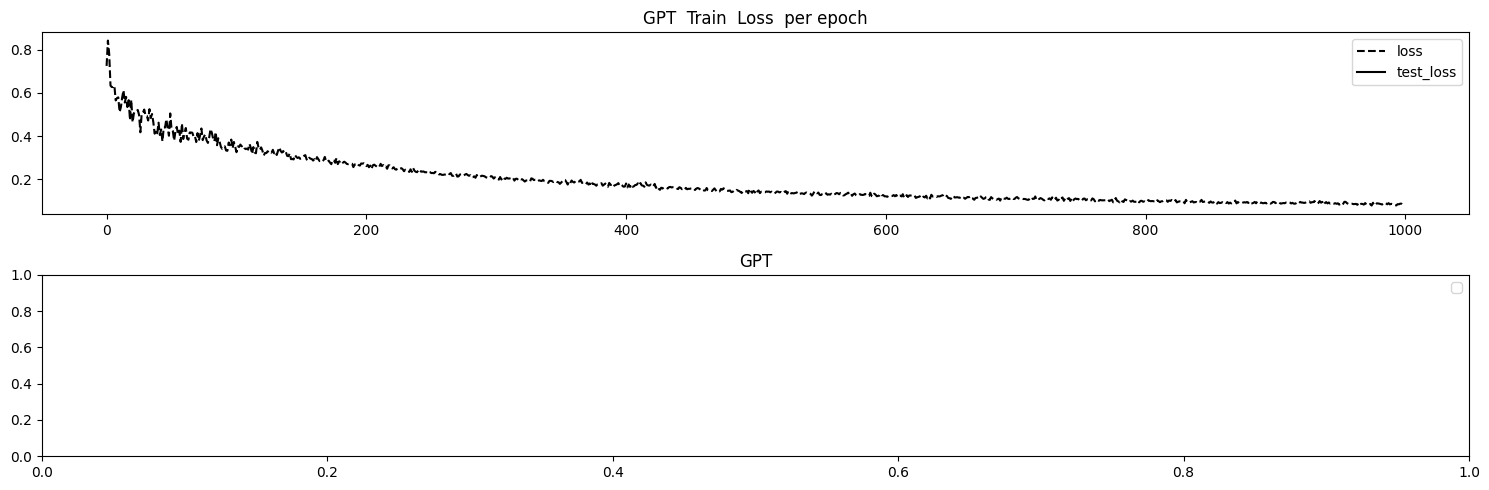

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

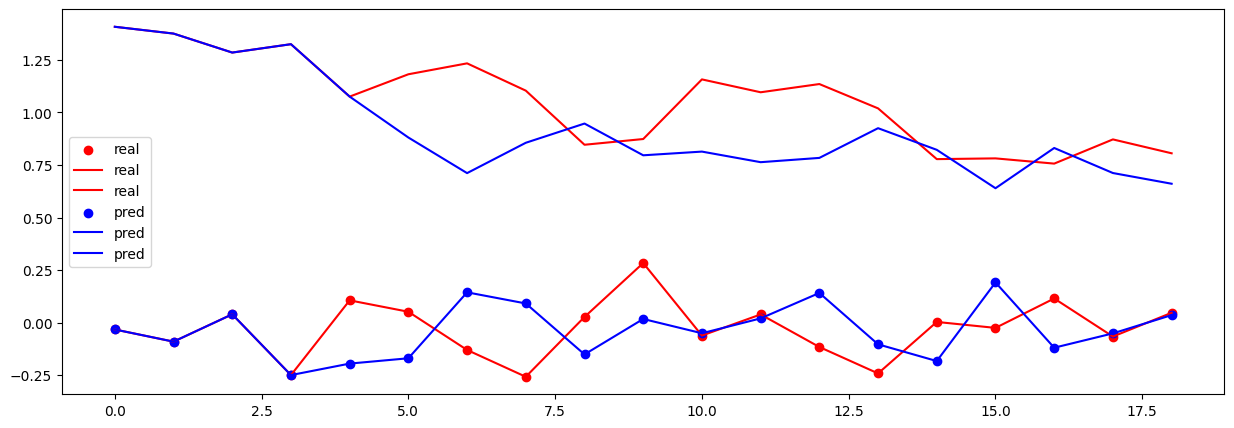

(100, 25)
119
19


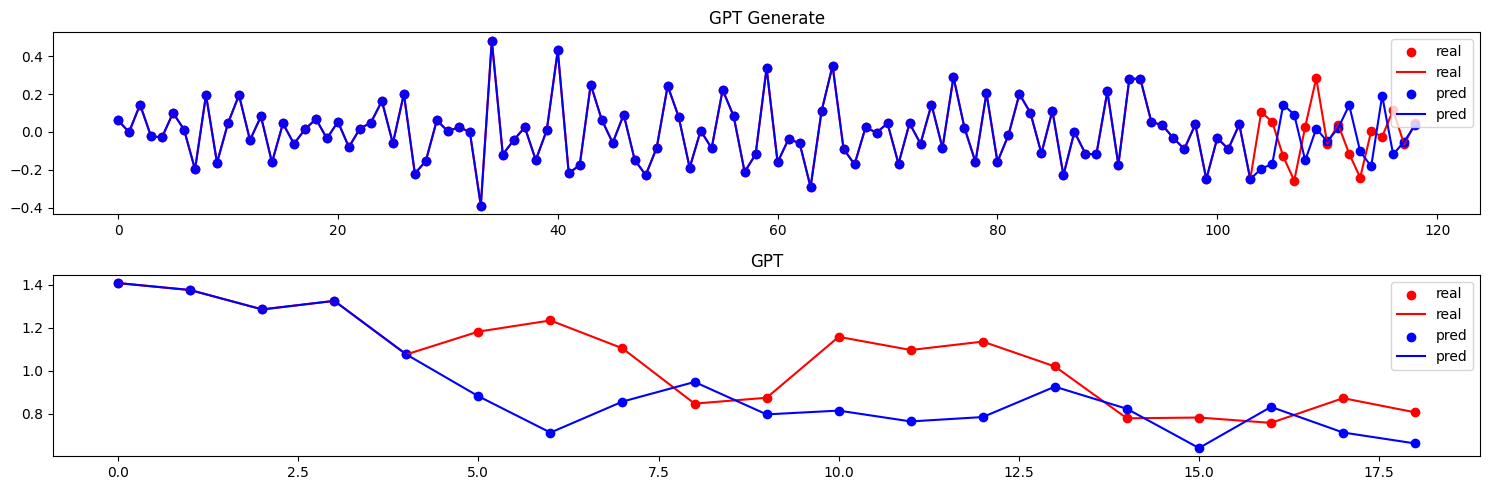

In [77]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



torch.Size([200, 25])
0 train loss =  0.819574236869812
500 train loss =  0.22251556813716888


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


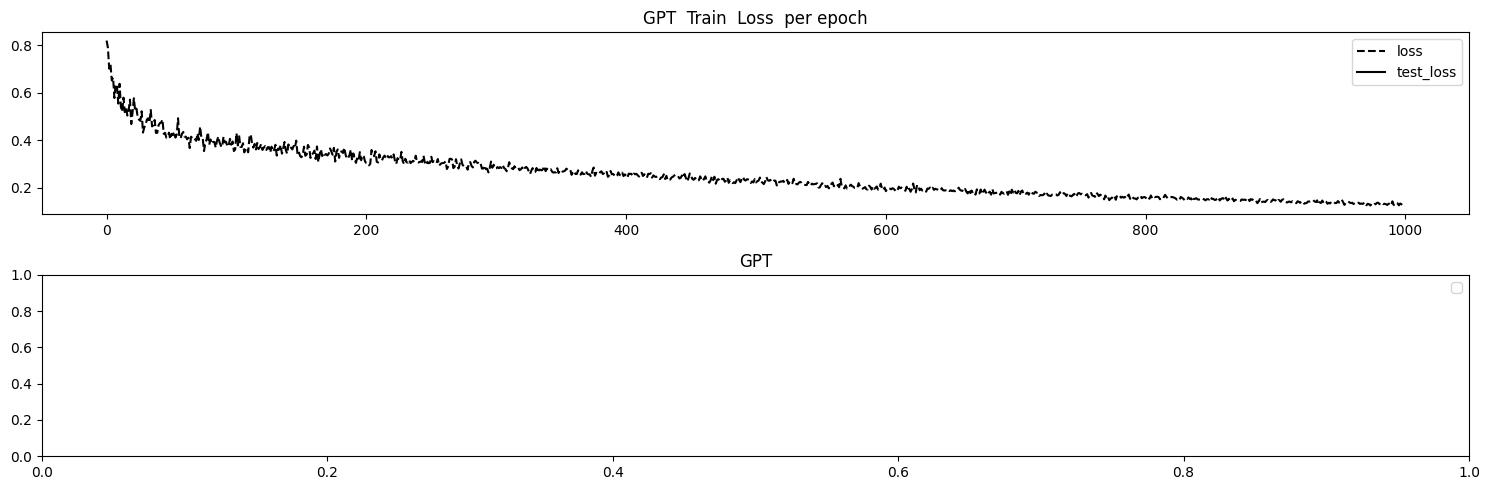

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

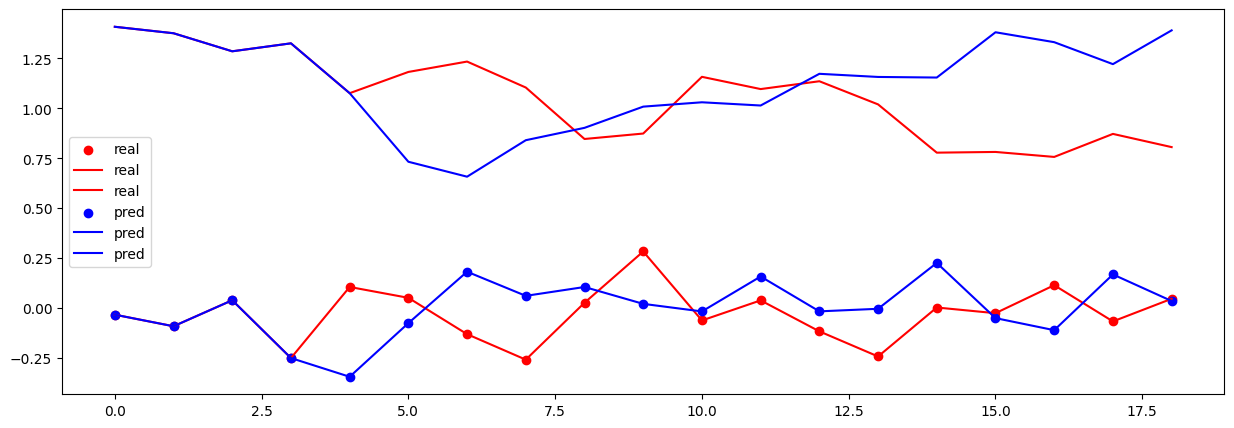

(200, 25)
219
19


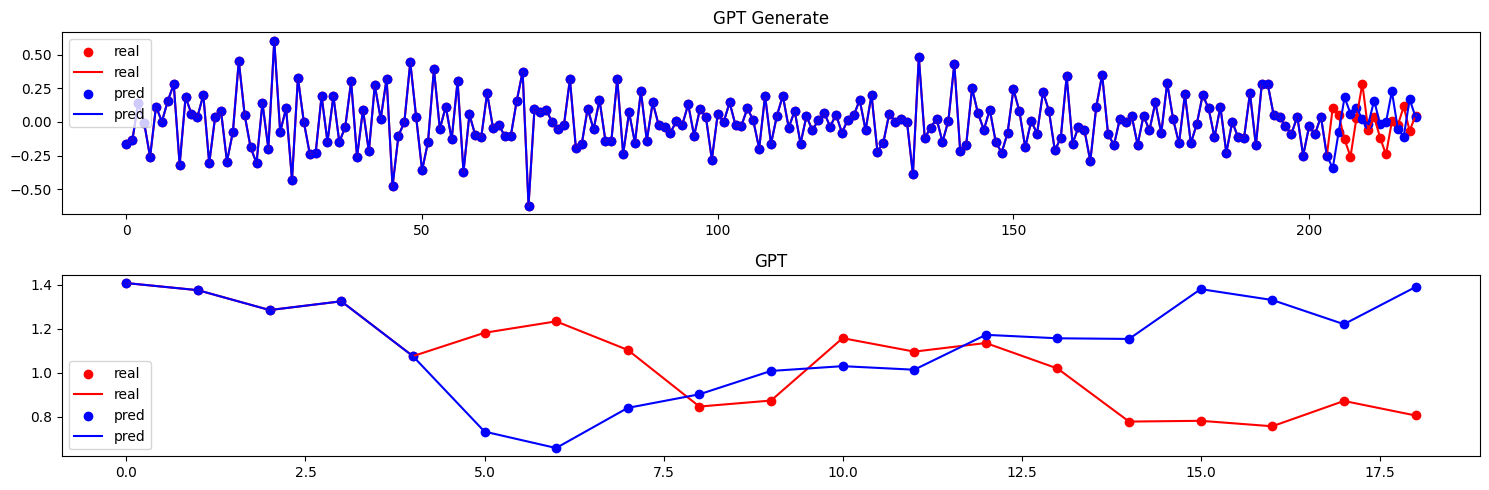

In [78]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



torch.Size([300, 25])
0 train loss =  0.9151156544685364
500 train loss =  0.24086181819438934


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


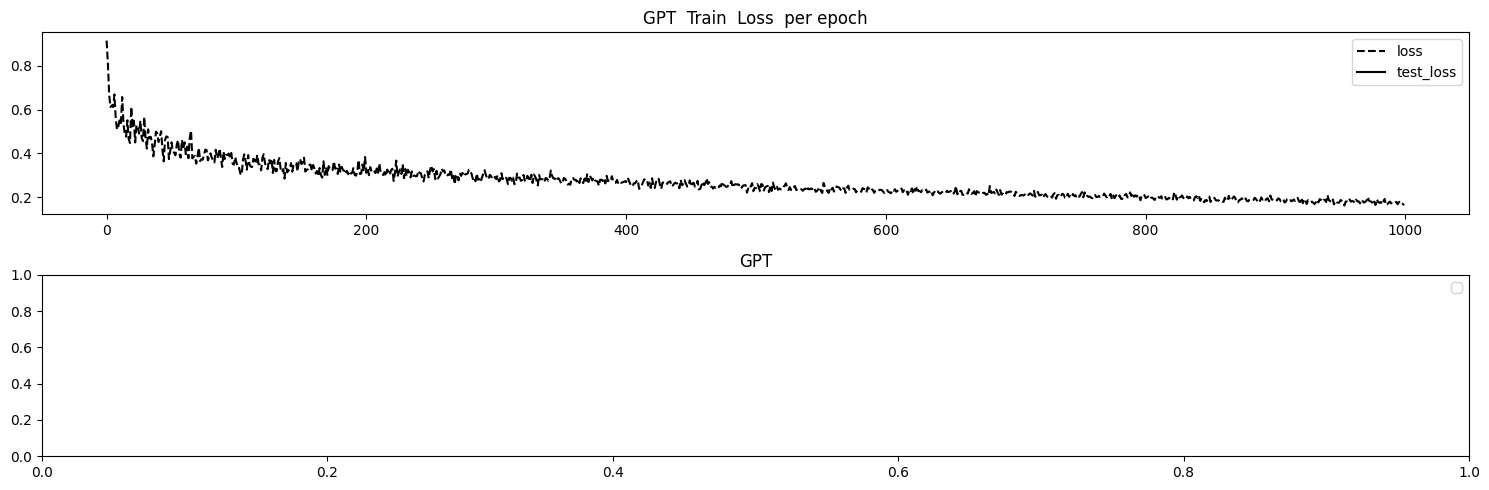

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

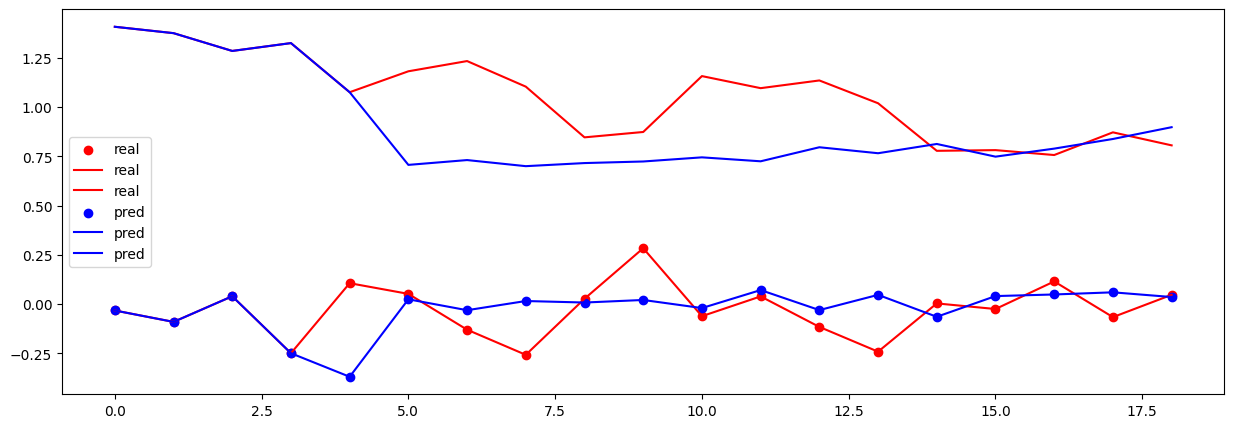

(300, 25)
319
19


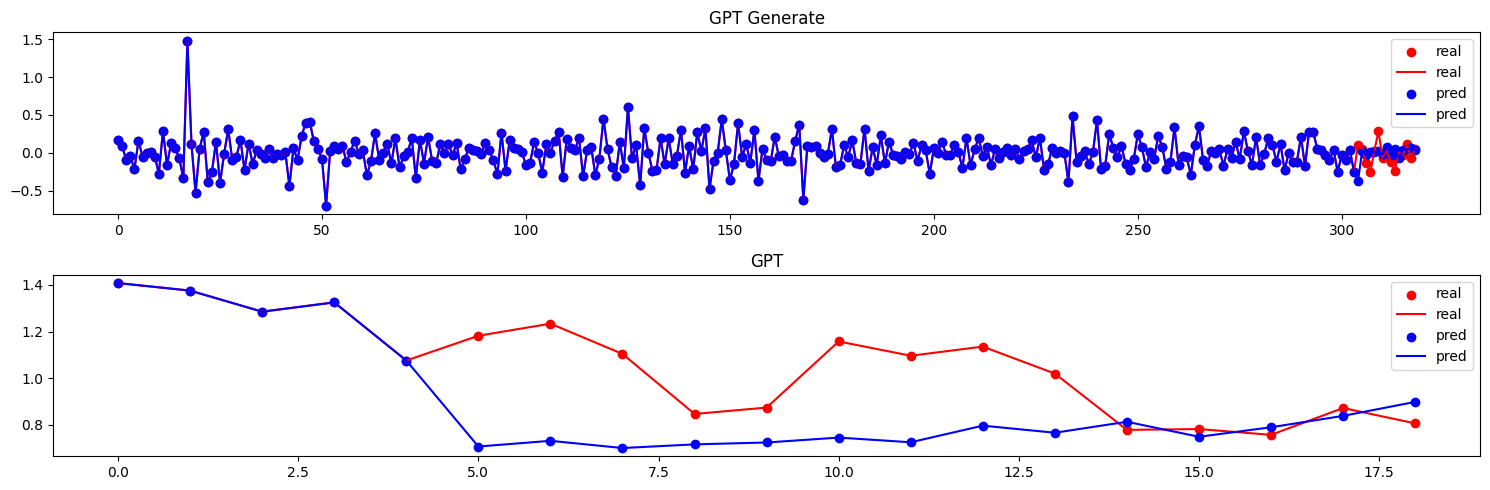

In [79]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([400, 25])
0 train loss =  0.8564794659614563
500 train loss =  0.272489458322525


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


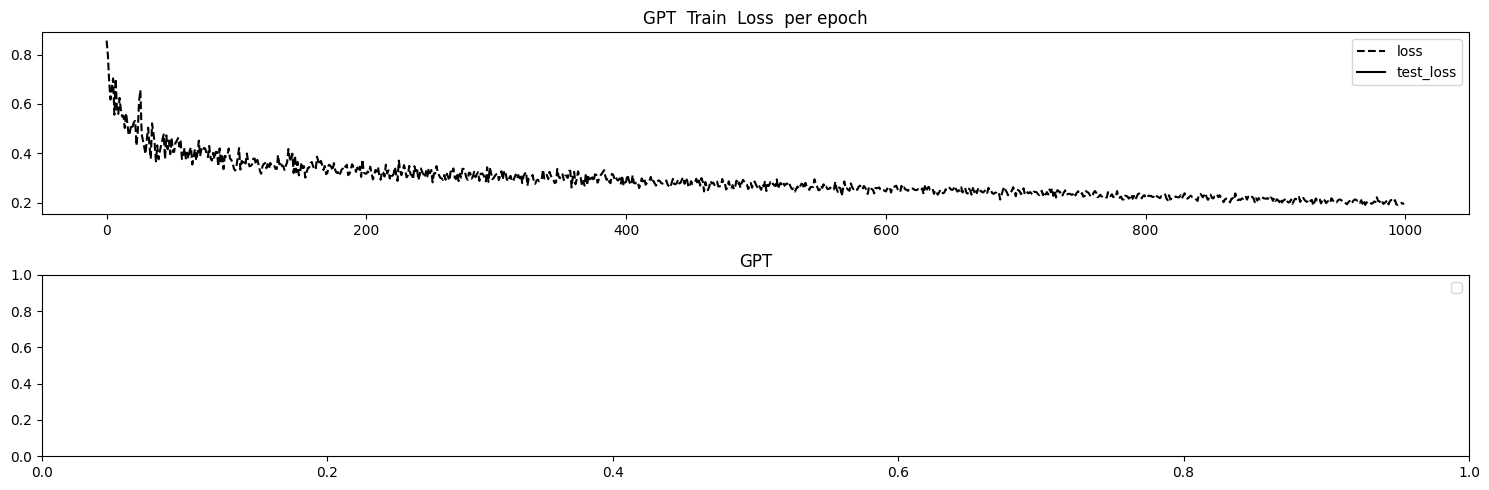

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

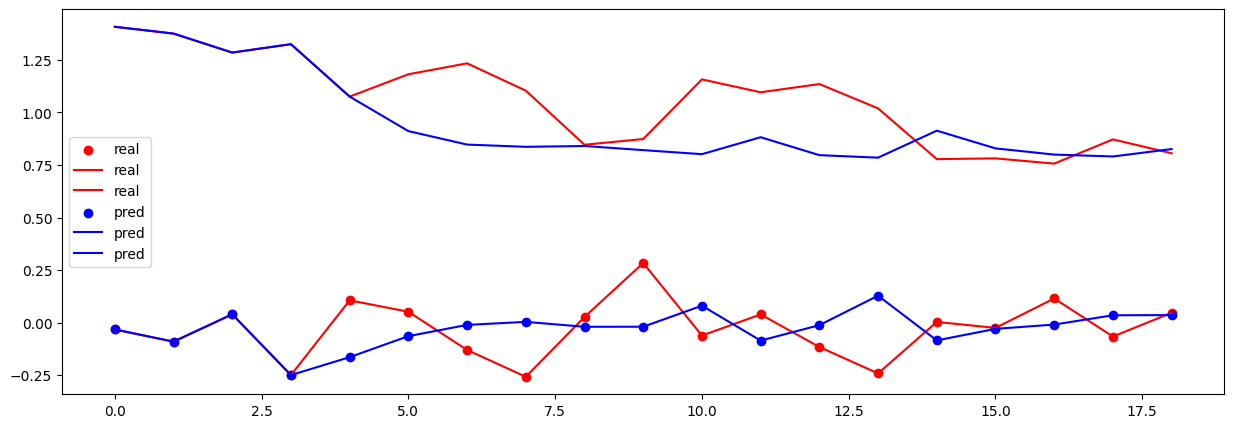

(400, 25)
419
19


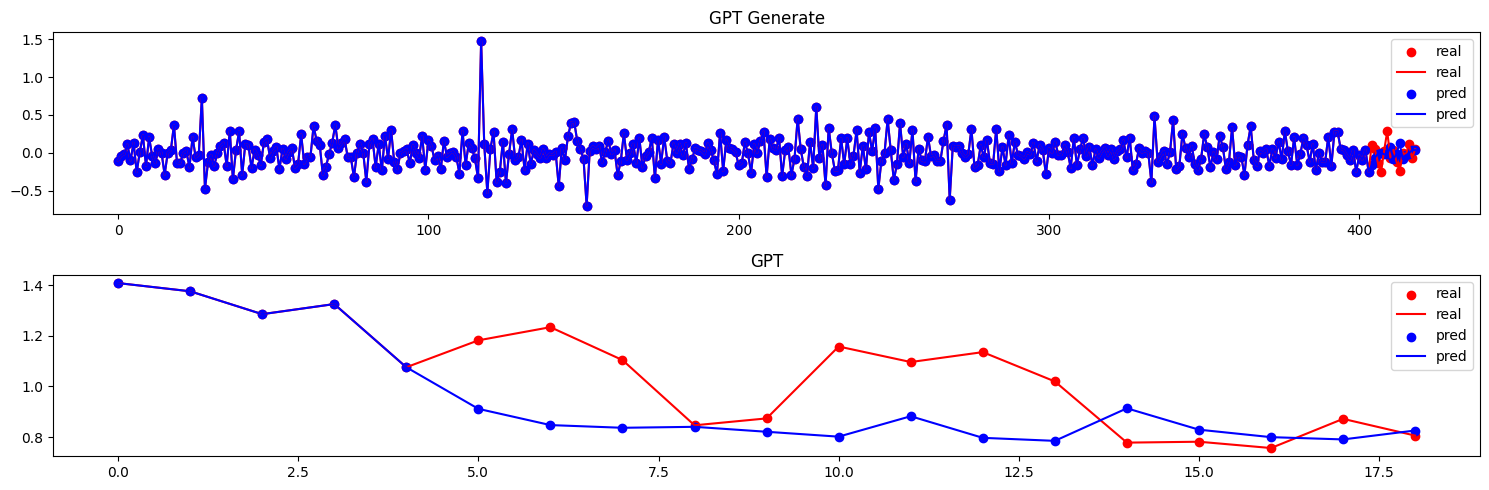

In [80]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 3


In [81]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )



1383
901
1316
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.824044406414032
500 train loss =  0.1578828990459442


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


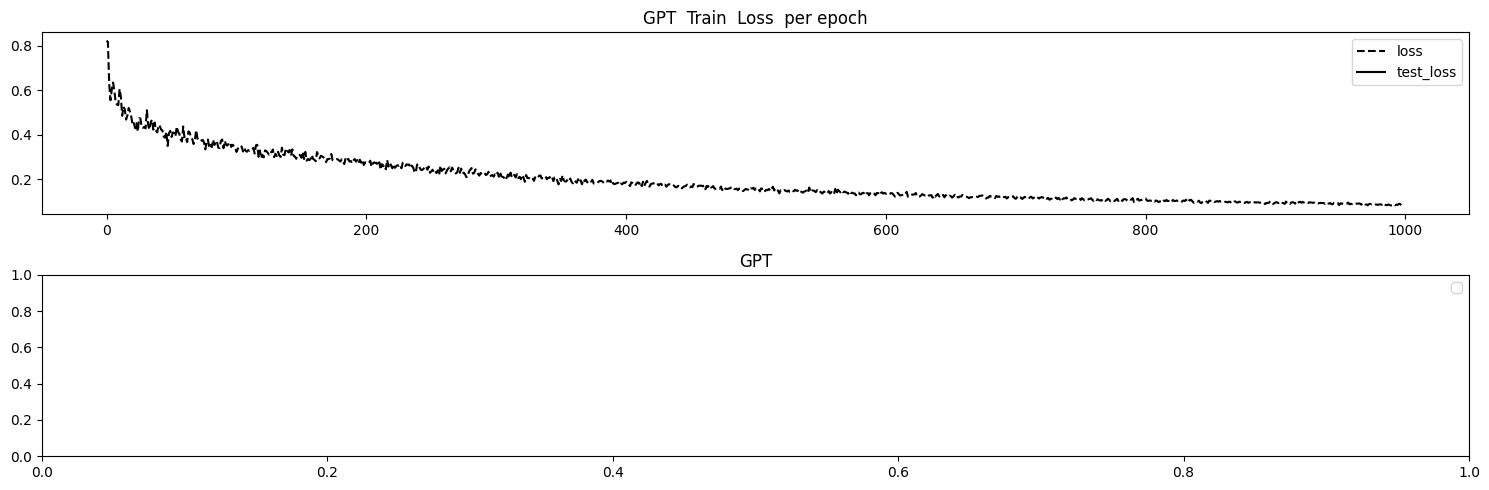

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

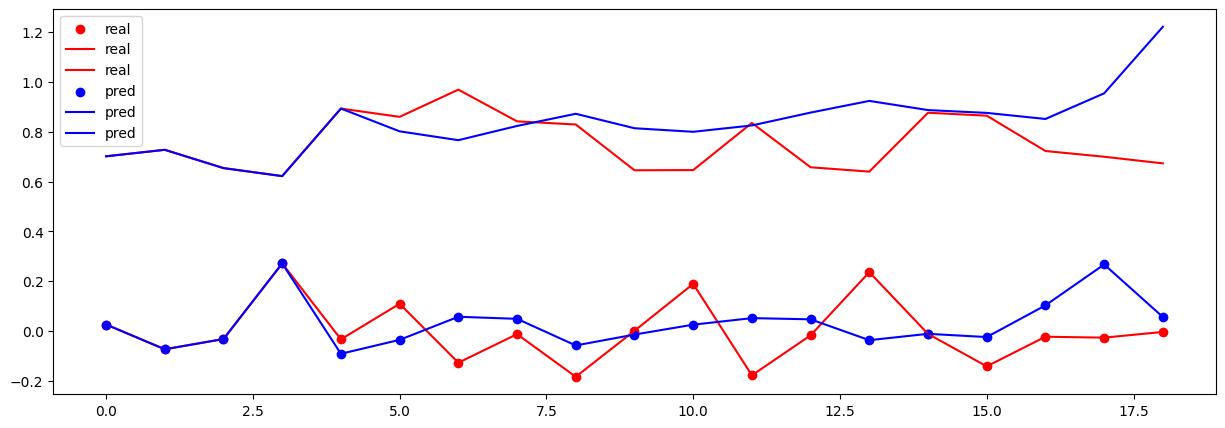

(100, 25)
119
19


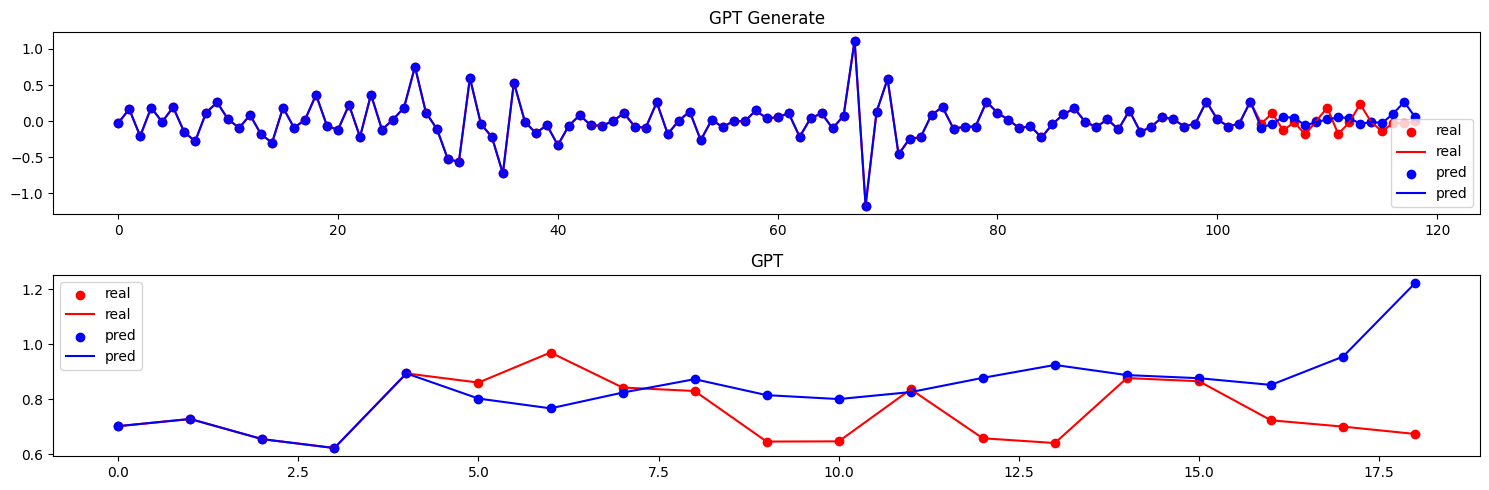

In [82]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



torch.Size([200, 25])
0 train loss =  0.8071509599685669
500 train loss =  0.22755584120750427


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


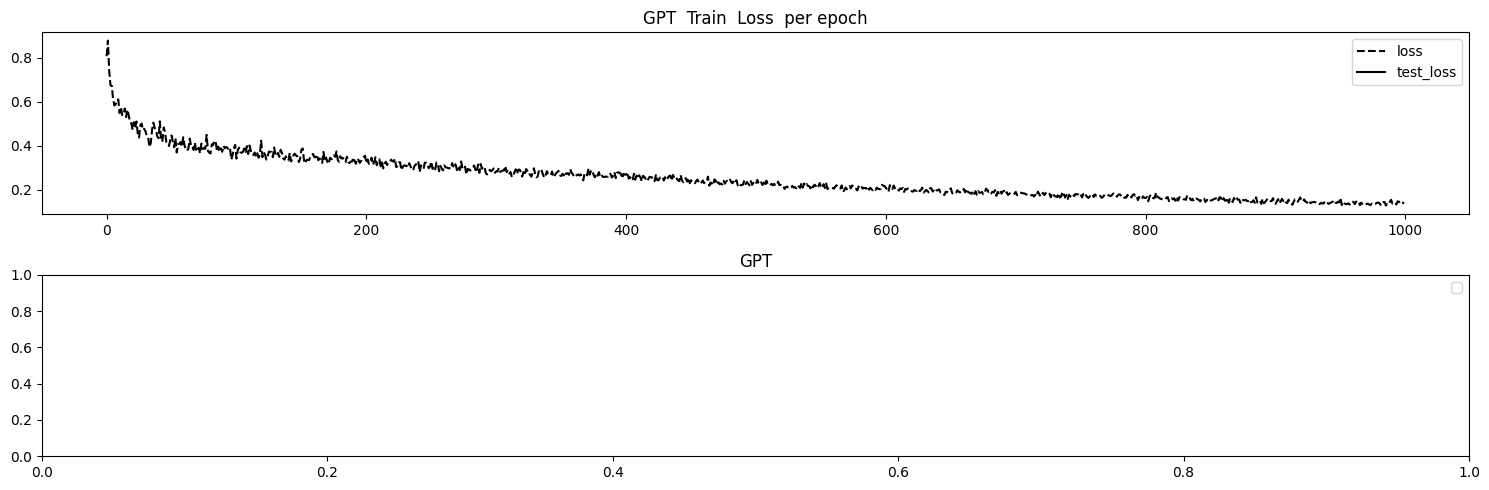

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

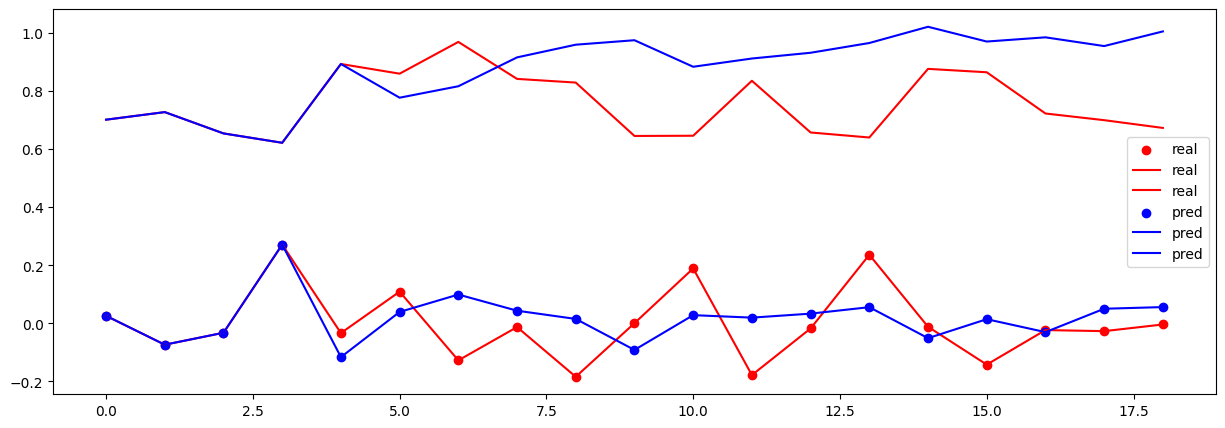

(200, 25)
219
19


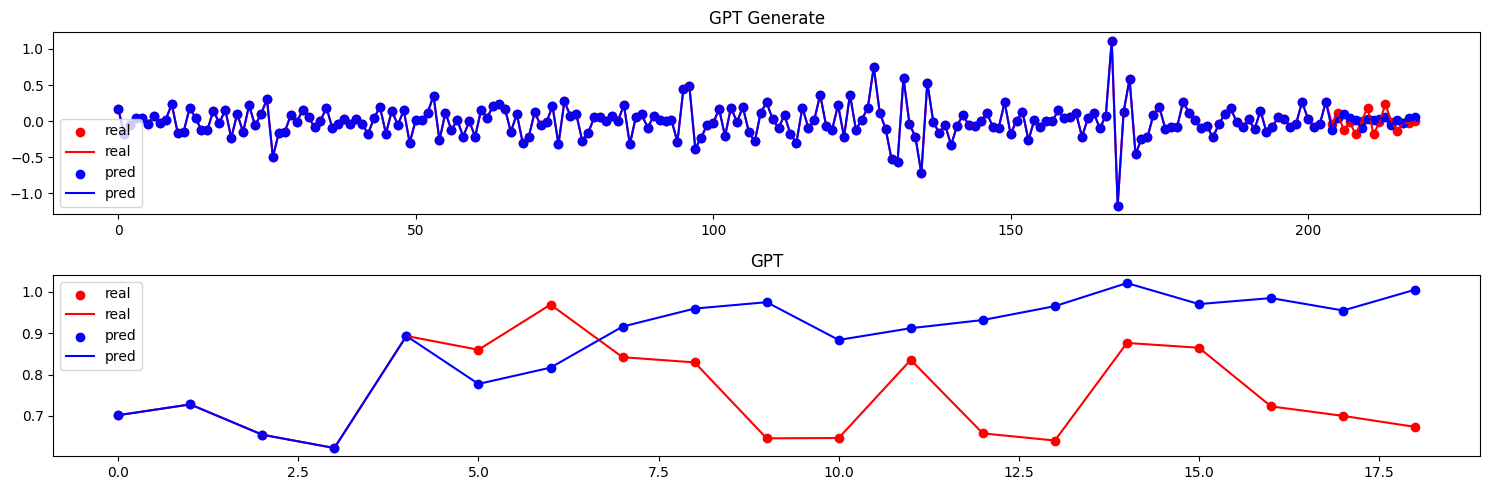

In [83]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



torch.Size([300, 25])
0 train loss =  0.8081424236297607
500 train loss =  0.23976391553878784


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


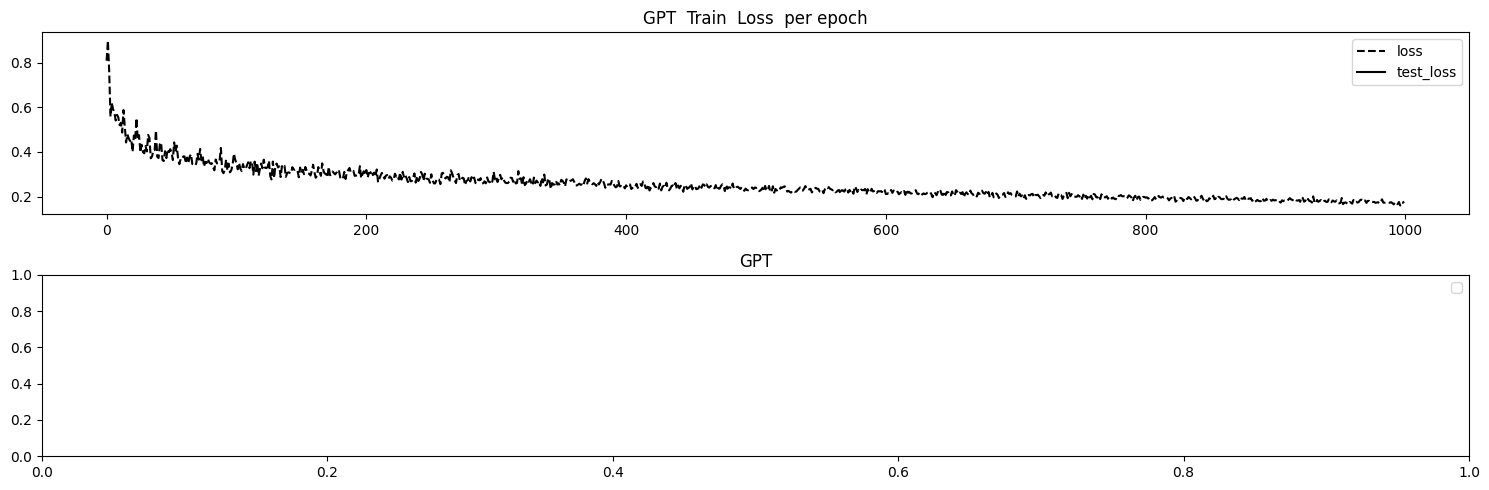

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

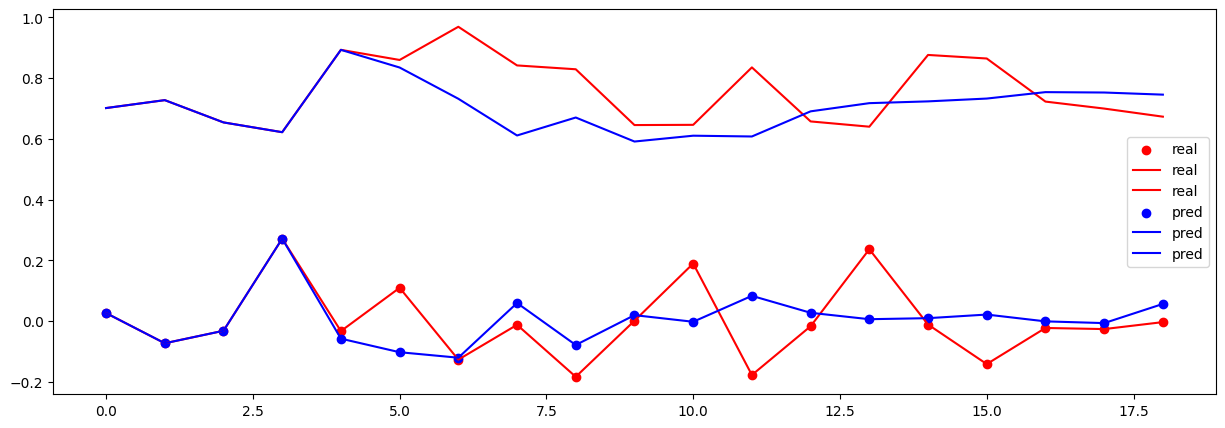

(300, 25)
319
19


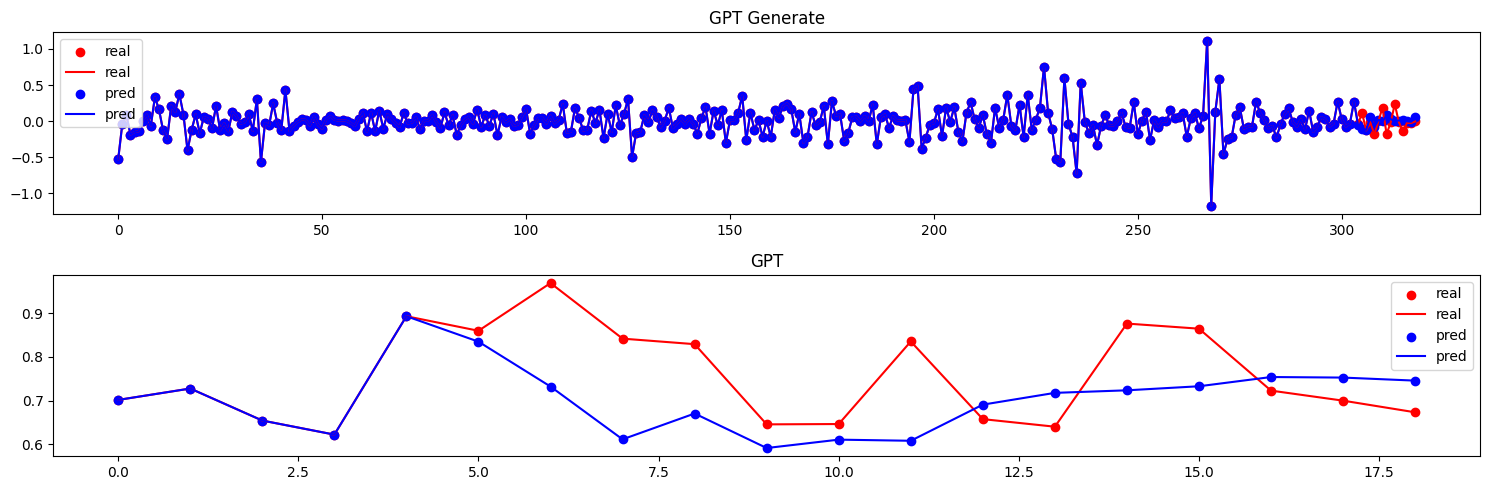

In [84]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([400, 25])
0 train loss =  0.916563093662262
500 train loss =  0.2629531919956207


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


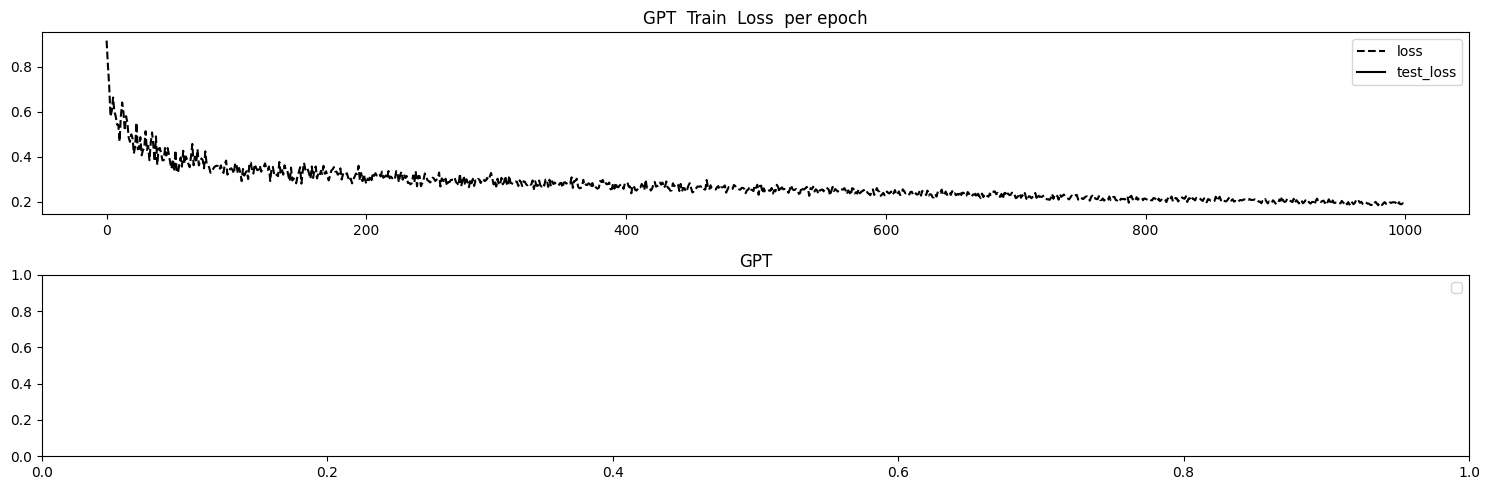

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

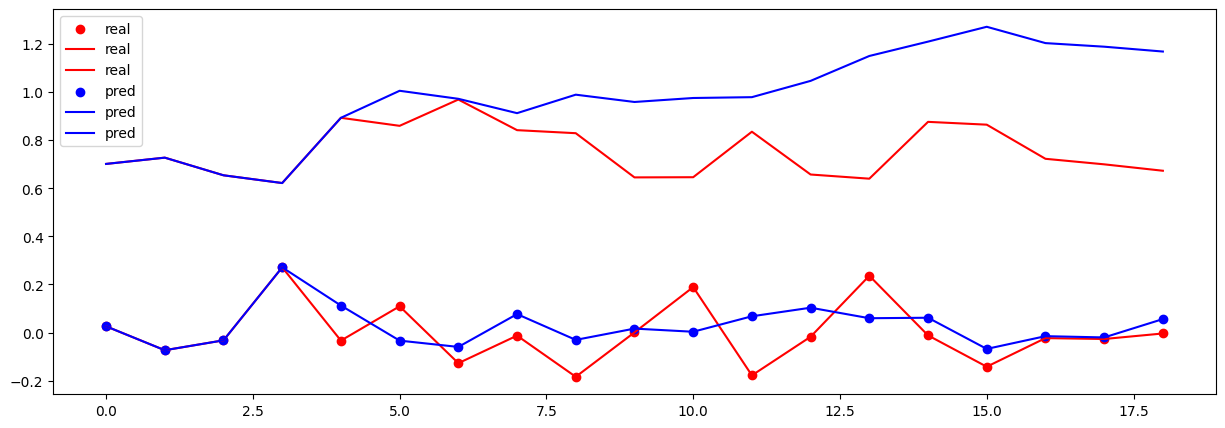

(400, 25)
419
19


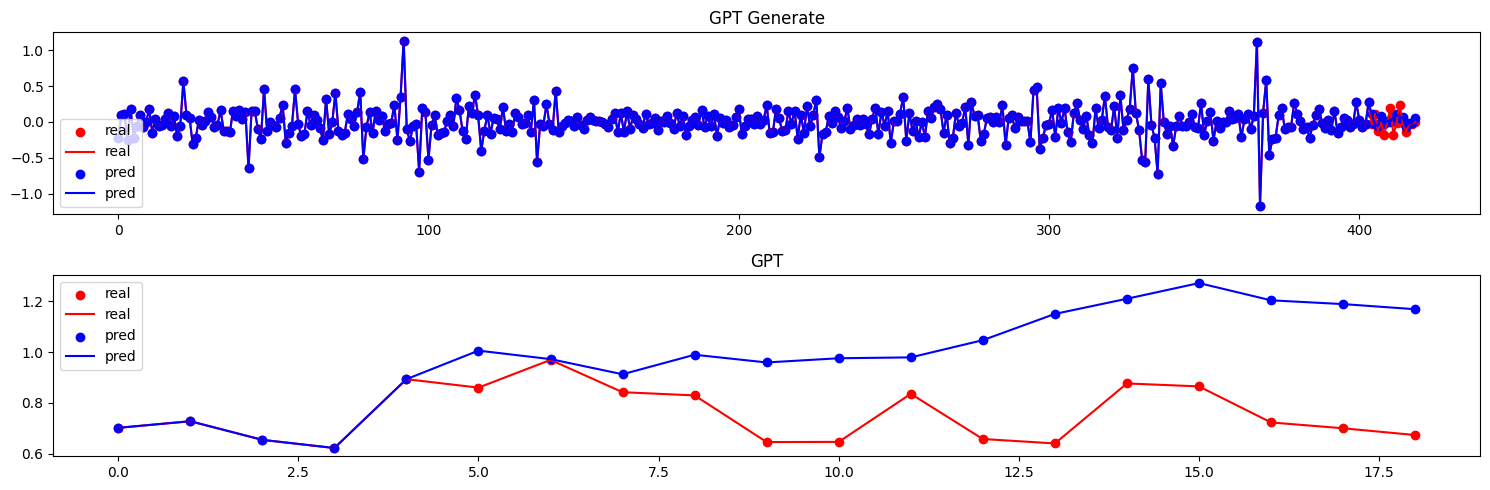

In [85]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 4


In [86]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
403
818
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.8163041472434998
500 train loss =  0.14549224078655243


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


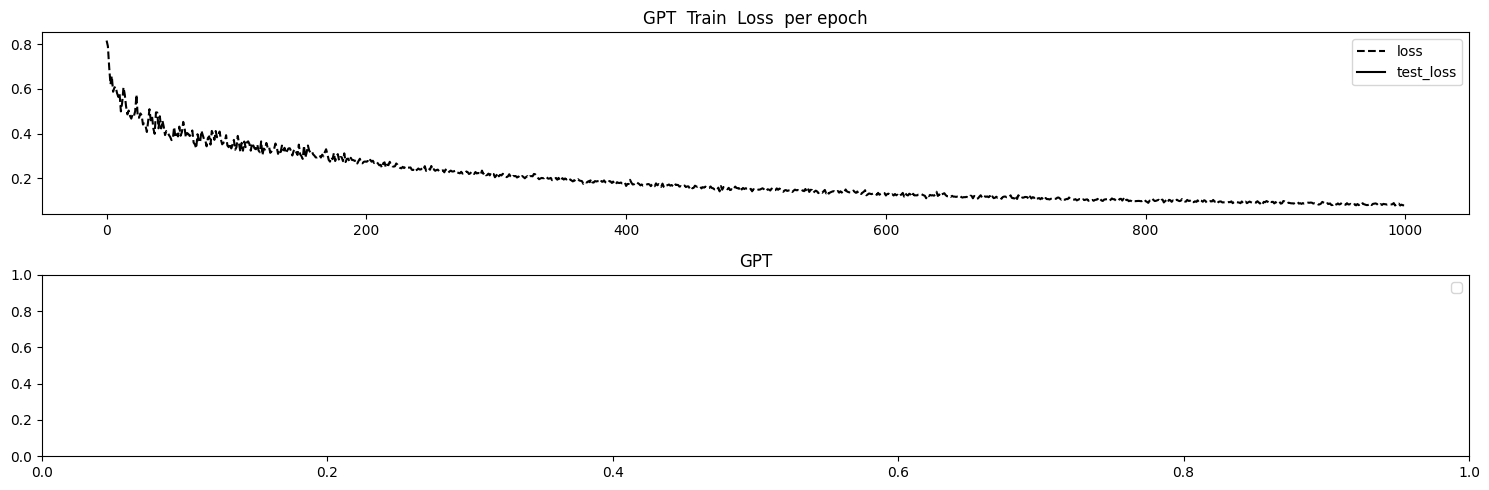

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

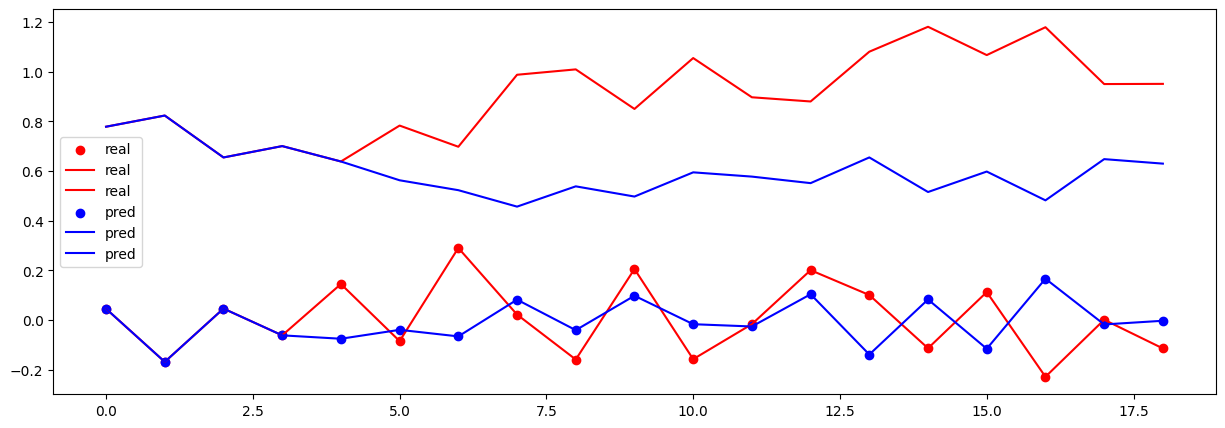

(100, 25)
119
19


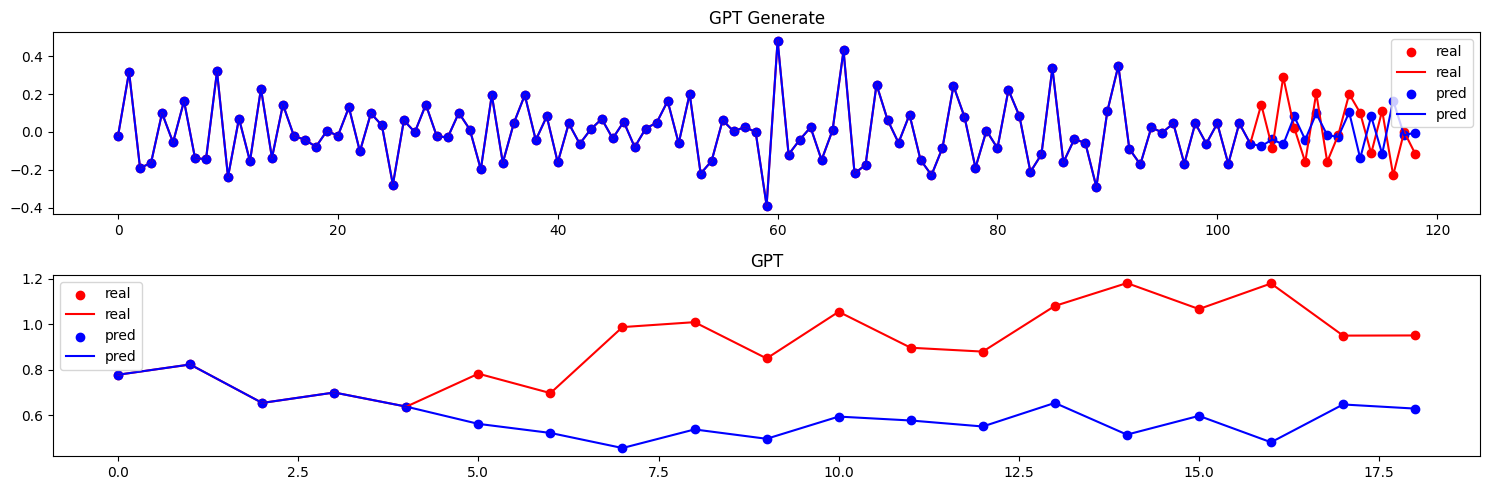

In [87]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([200, 25])
0 train loss =  0.8462629914283752
500 train loss =  0.2210102528333664


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


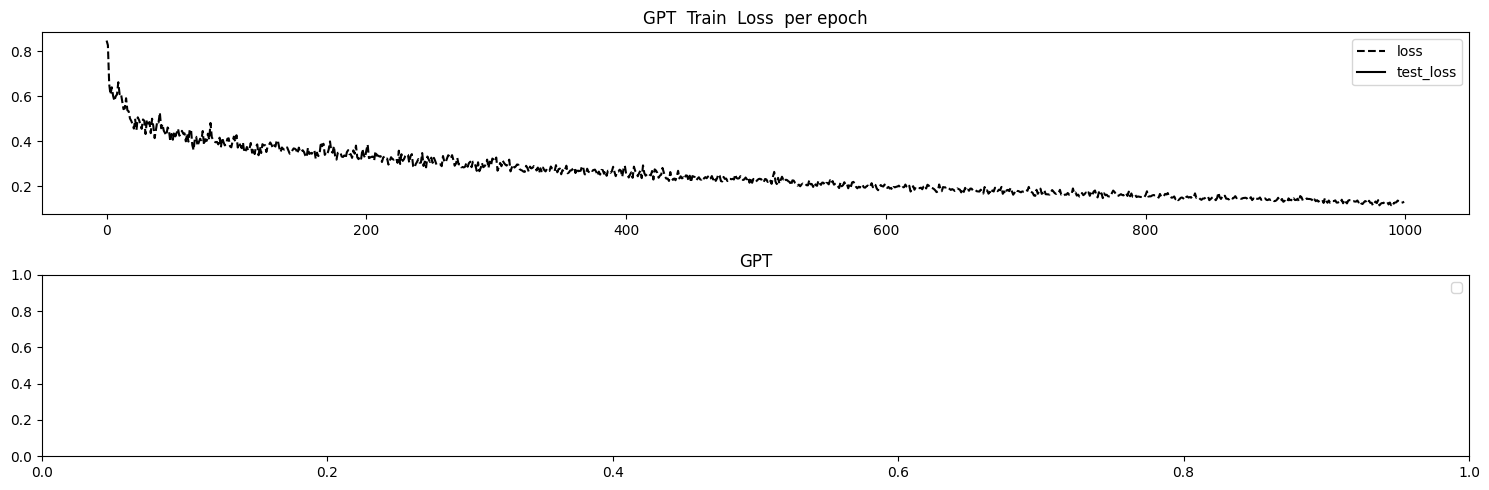

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

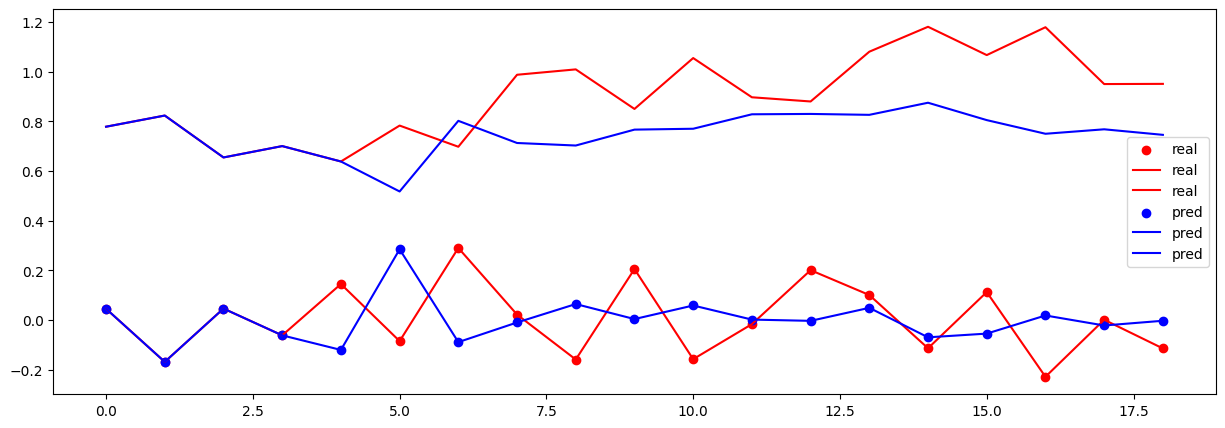

(200, 25)
219
19


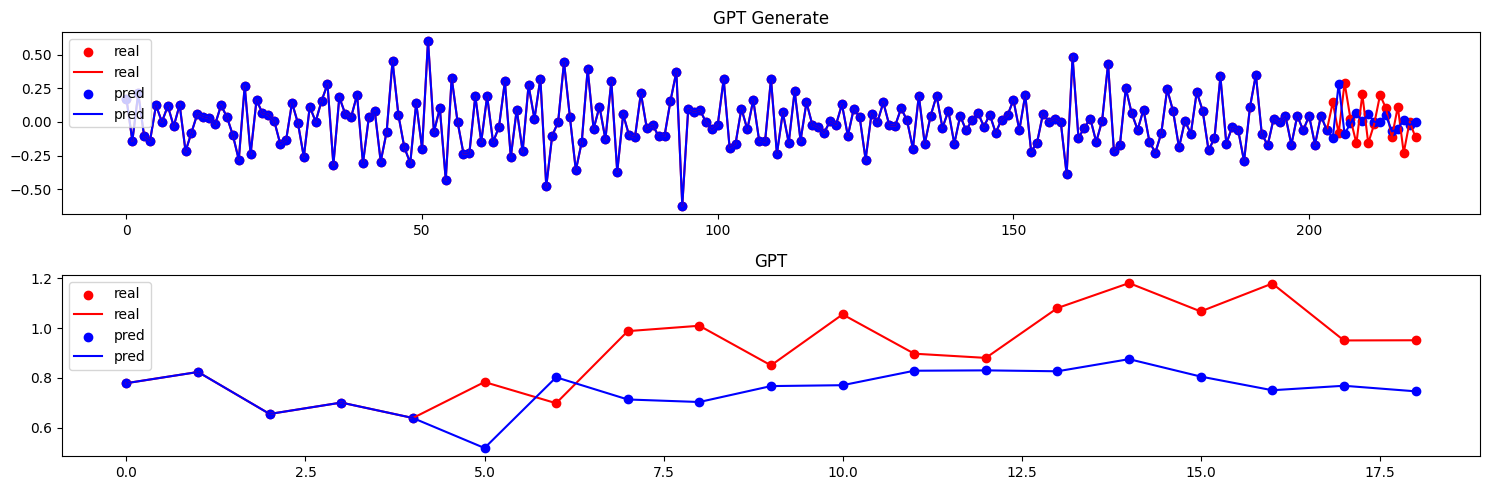

In [88]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



torch.Size([300, 25])
0 train loss =  0.8570672869682312
500 train loss =  0.22475777566432953


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


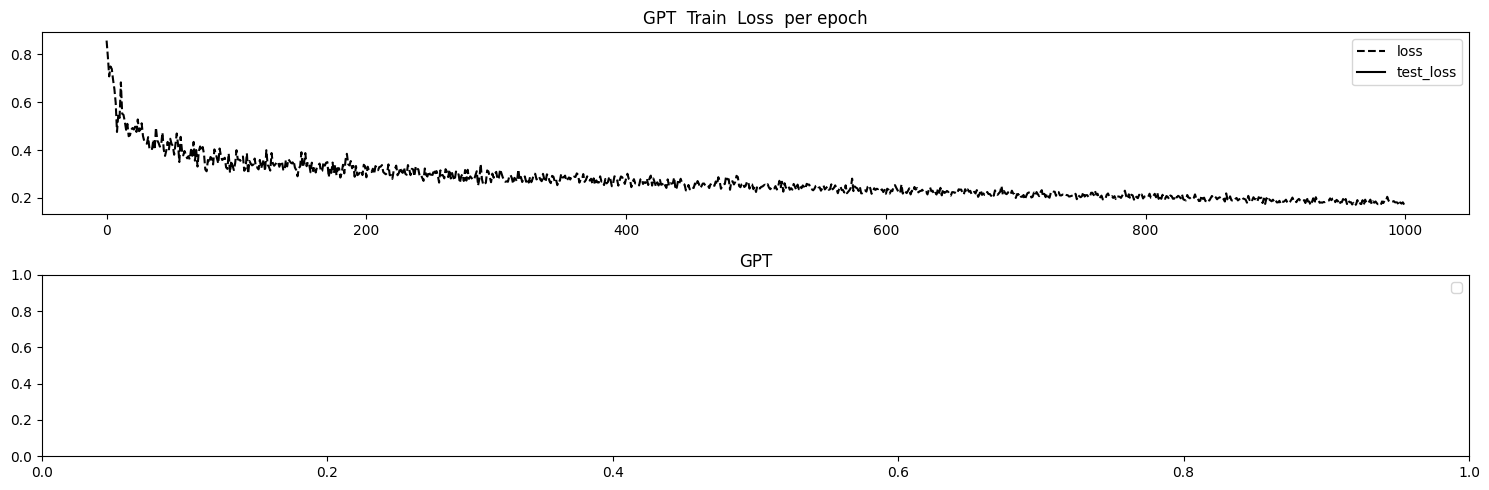

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

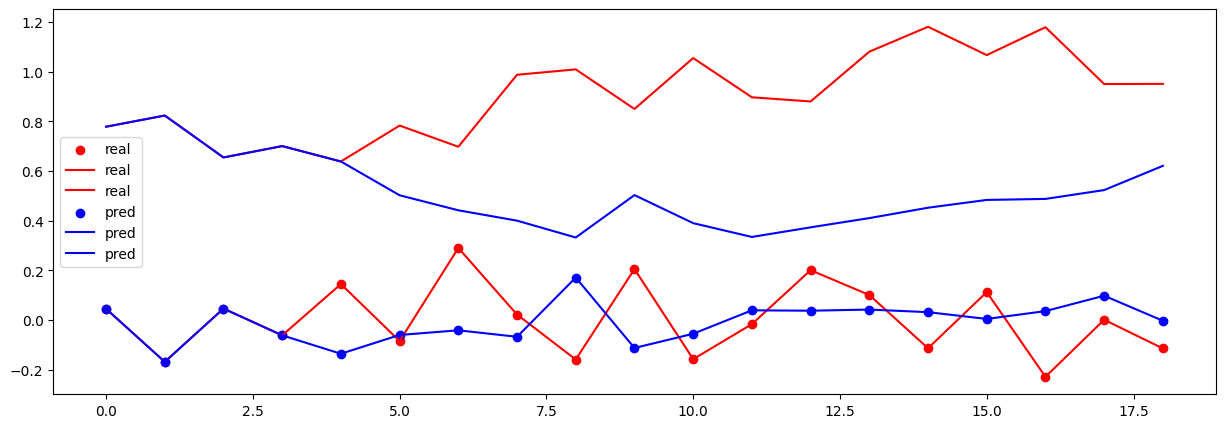

(300, 25)
319
19


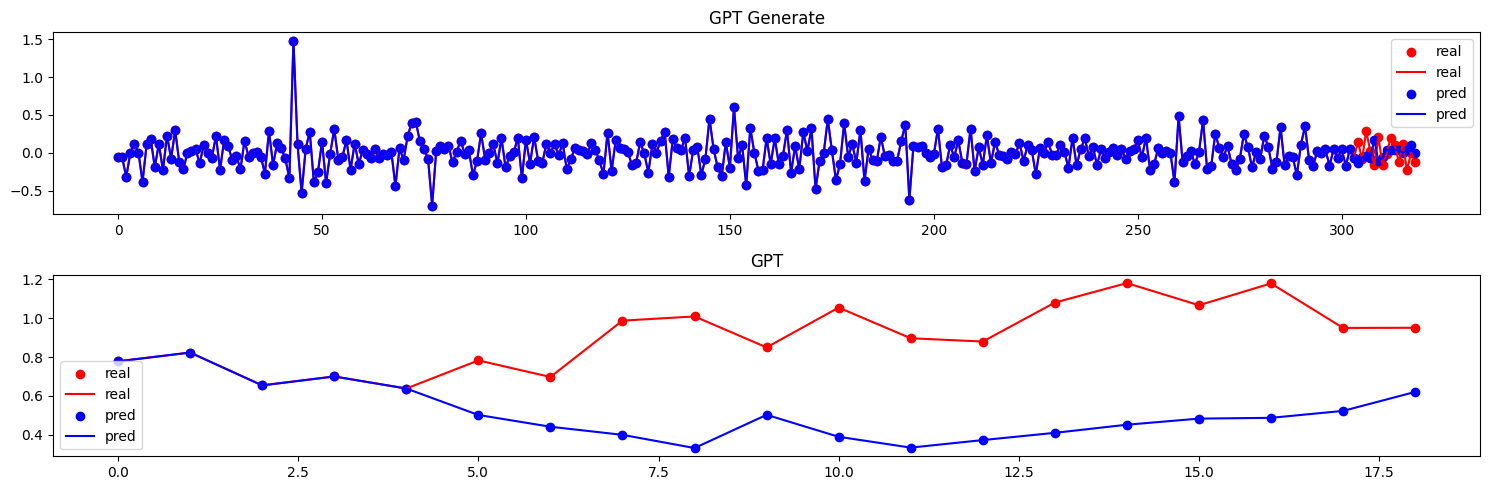

In [89]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



torch.Size([400, 25])
0 train loss =  0.8959136605262756
500 train loss =  0.27556368708610535


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


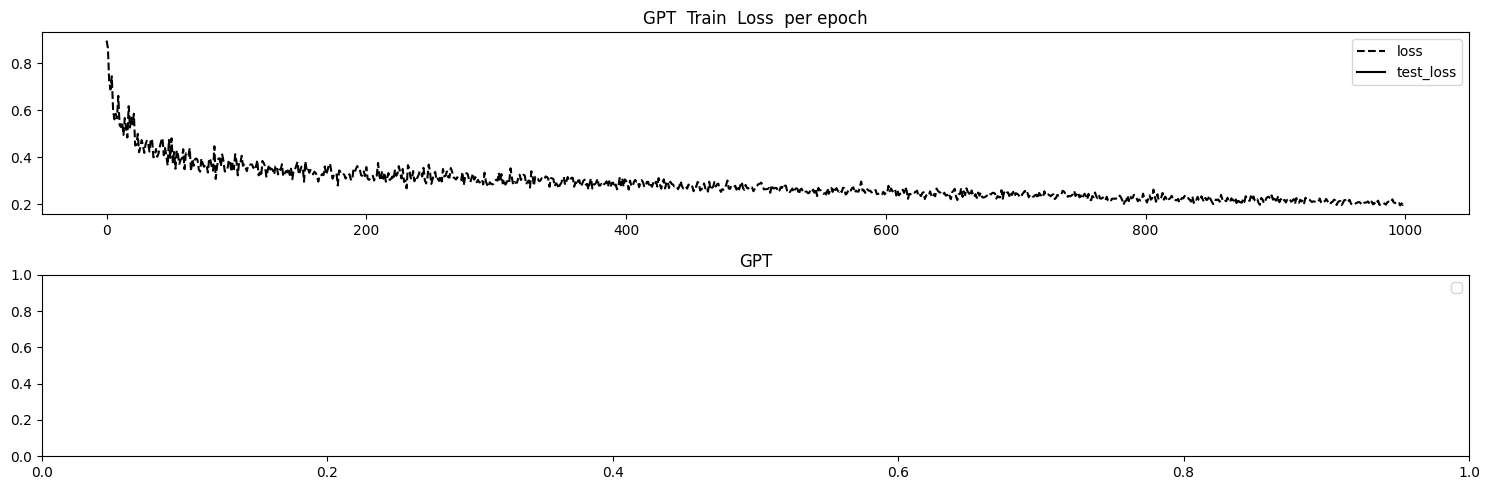

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

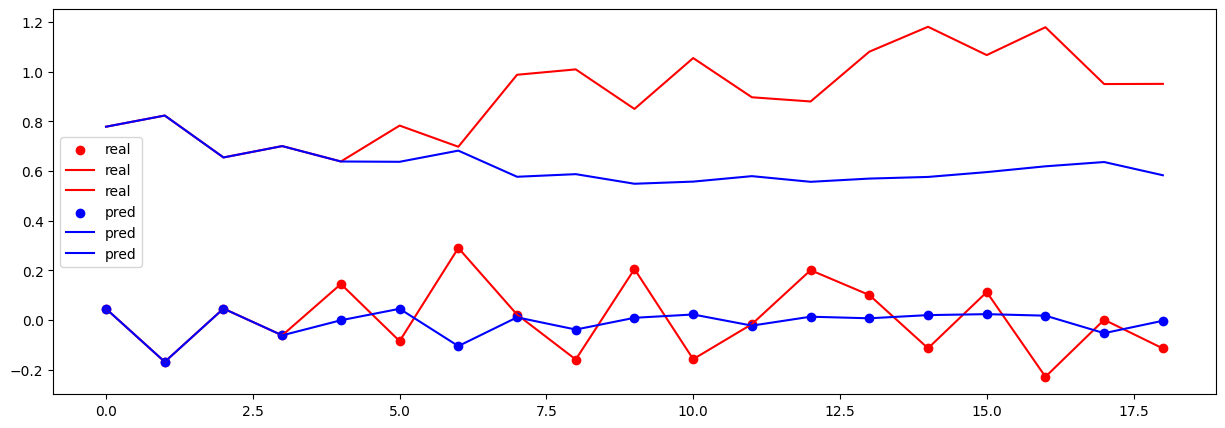

(400, 25)
419
19


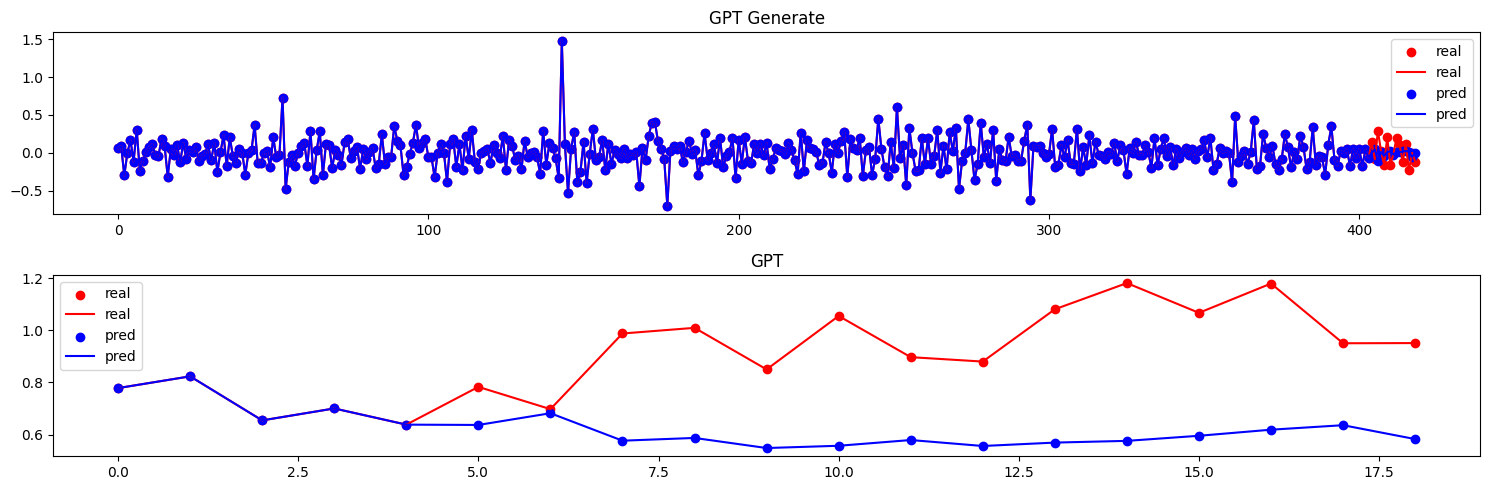

In [90]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 5


In [91]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
95
510
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.856083333492279
500 train loss =  0.15543638169765472


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


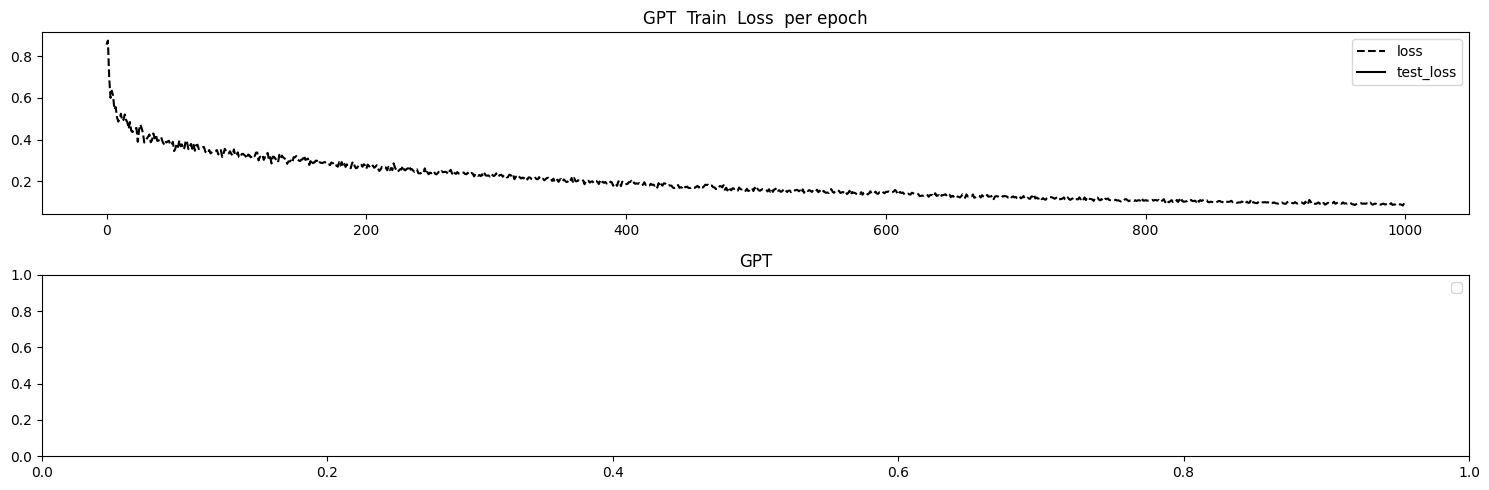

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

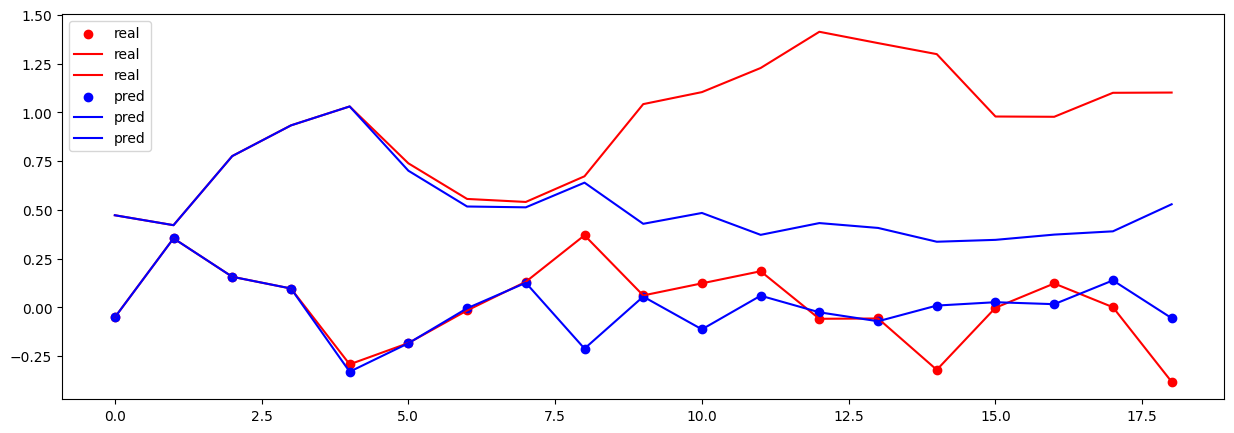

(100, 25)
119
19


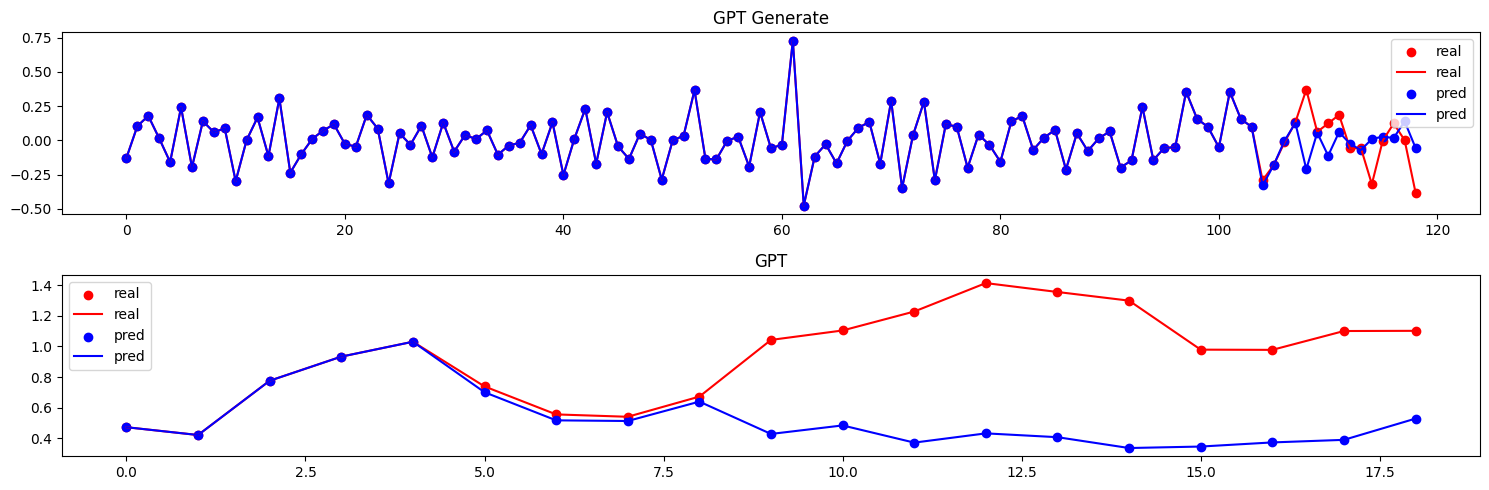

In [92]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



torch.Size([200, 25])
0 train loss =  0.9416100978851318
500 train loss =  0.22490966320037842


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


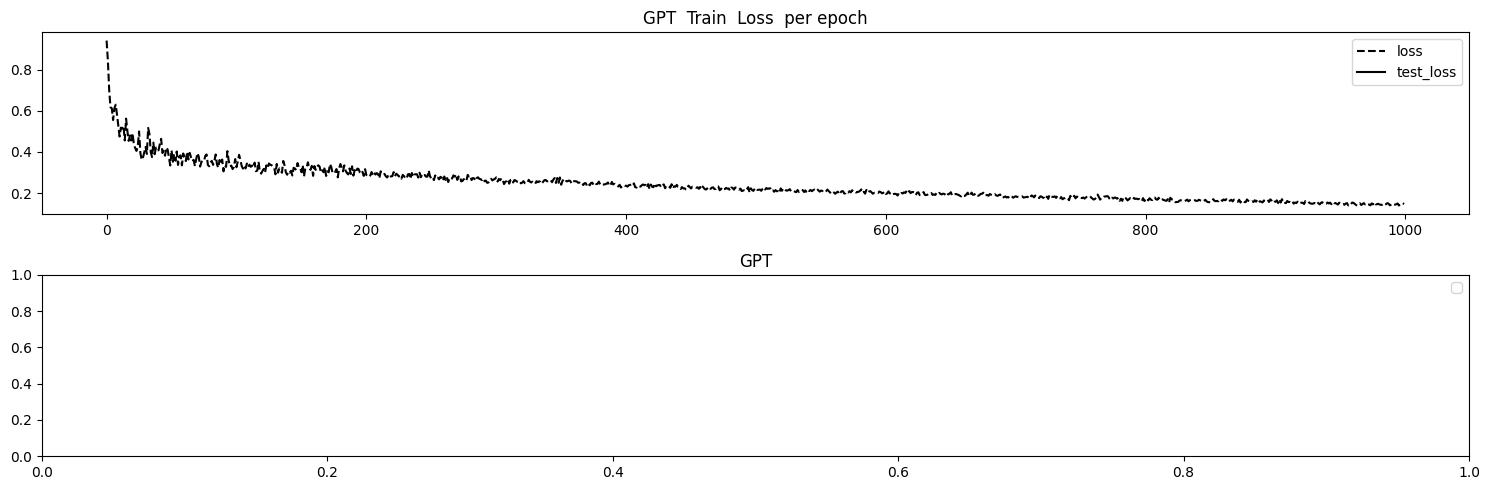

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

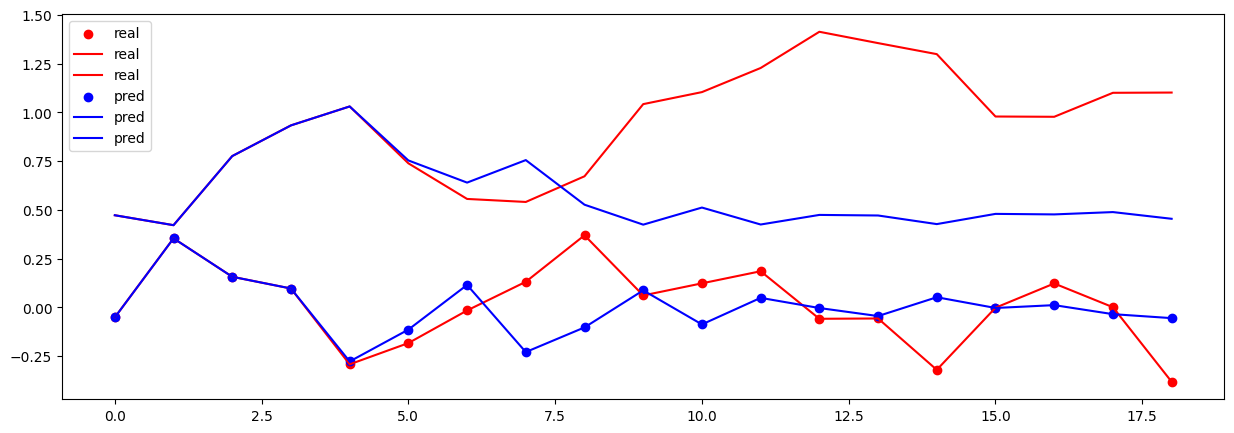

(200, 25)
219
19


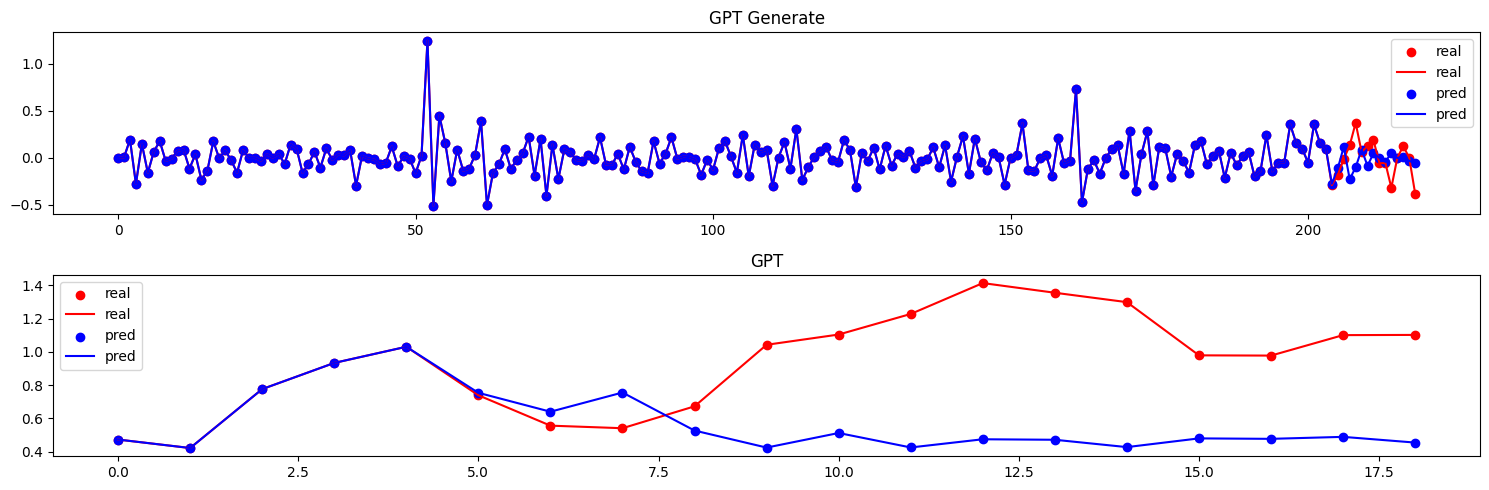

In [93]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([300, 25])
0 train loss =  0.821796715259552
500 train loss =  0.22823786735534668


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


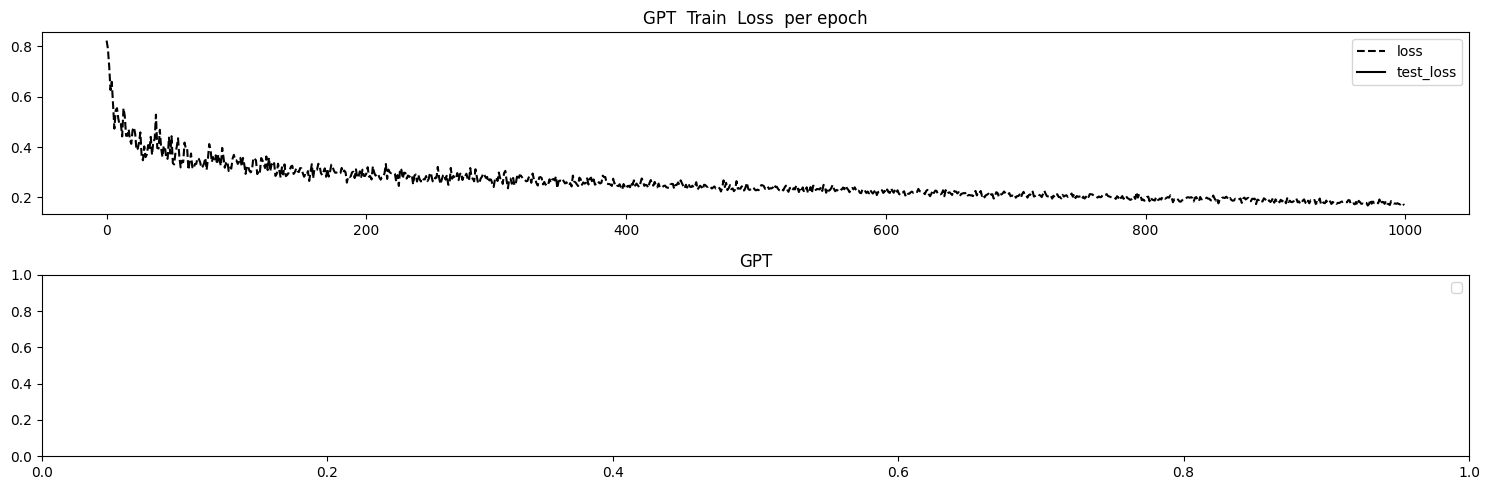

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

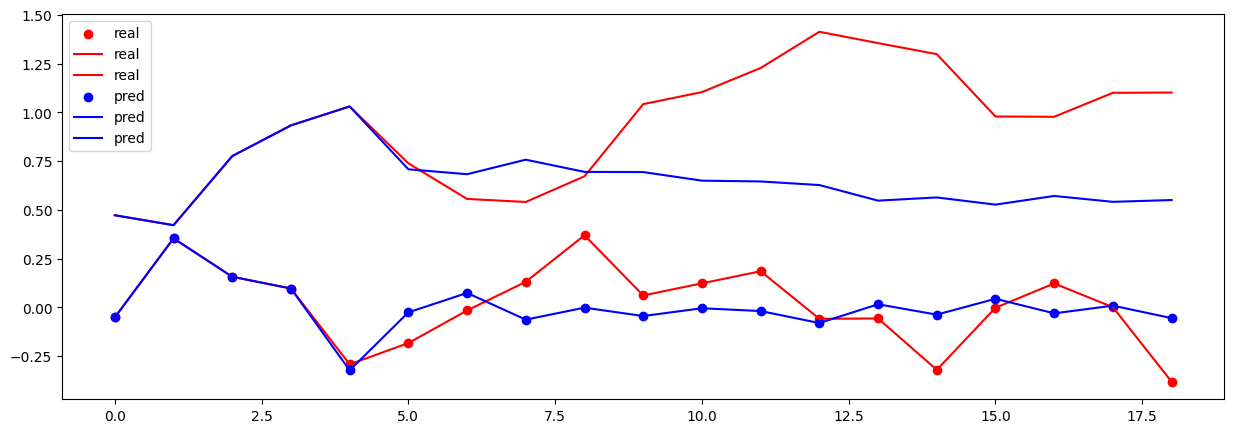

(300, 25)
319
19


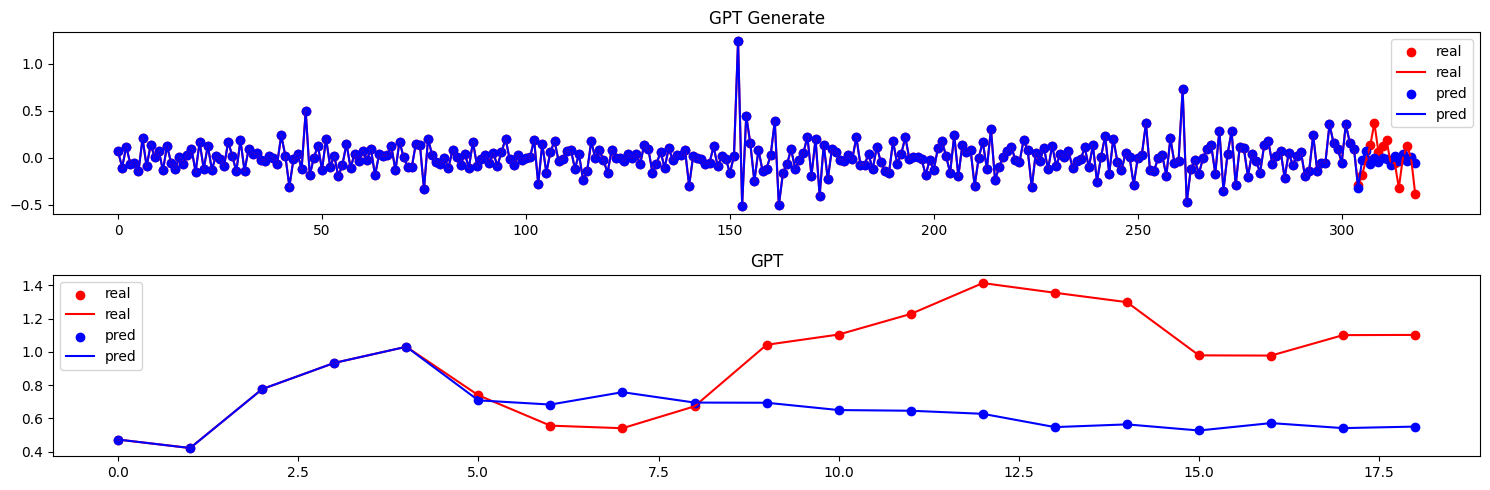

In [94]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([400, 25])
0 train loss =  0.9373010396957397
500 train loss =  0.23900942504405975


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


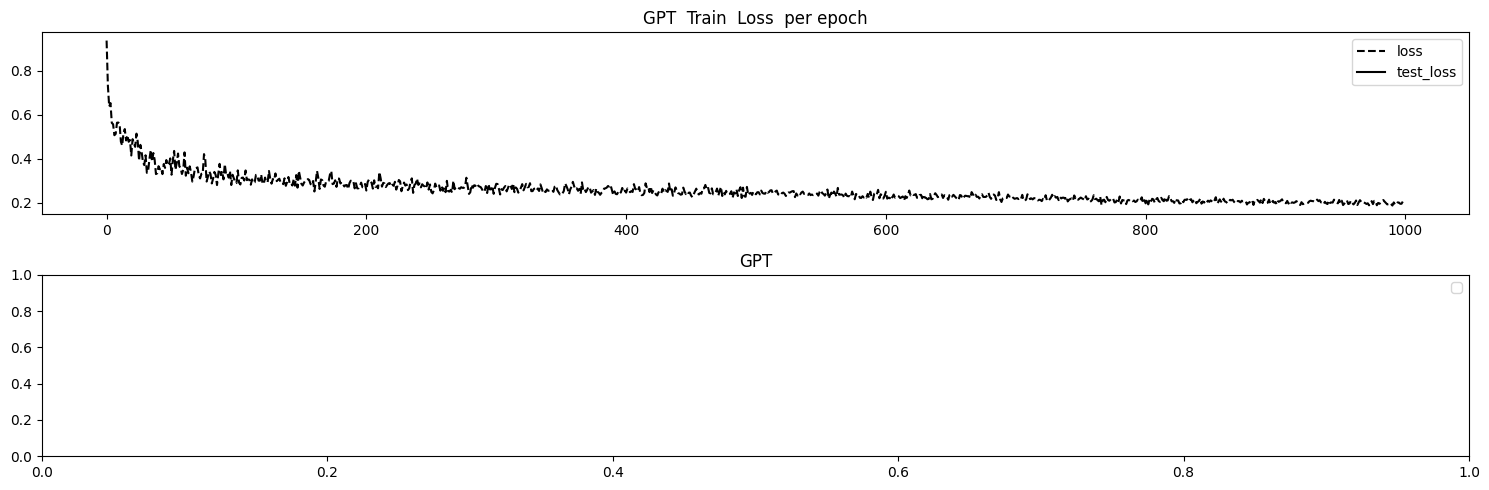

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

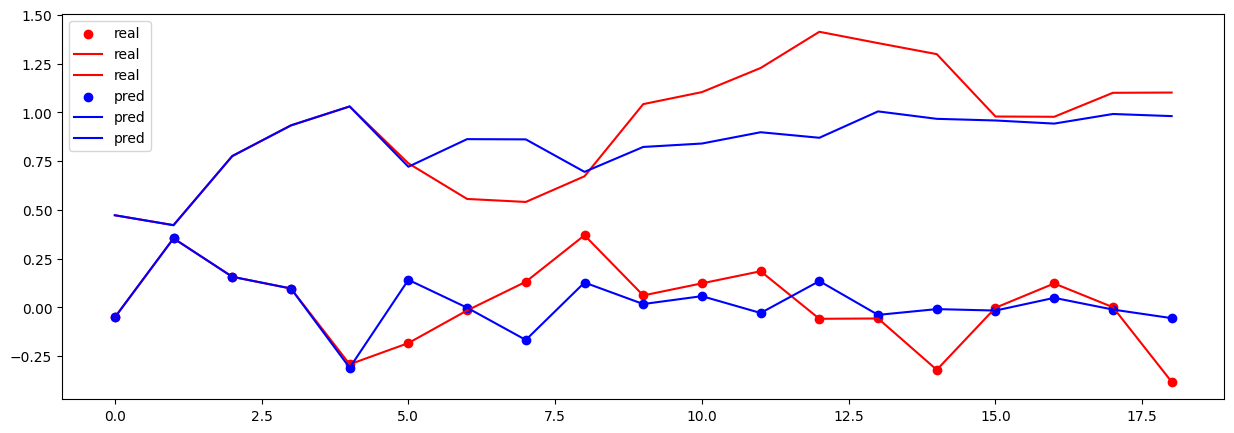

(400, 25)
419
19


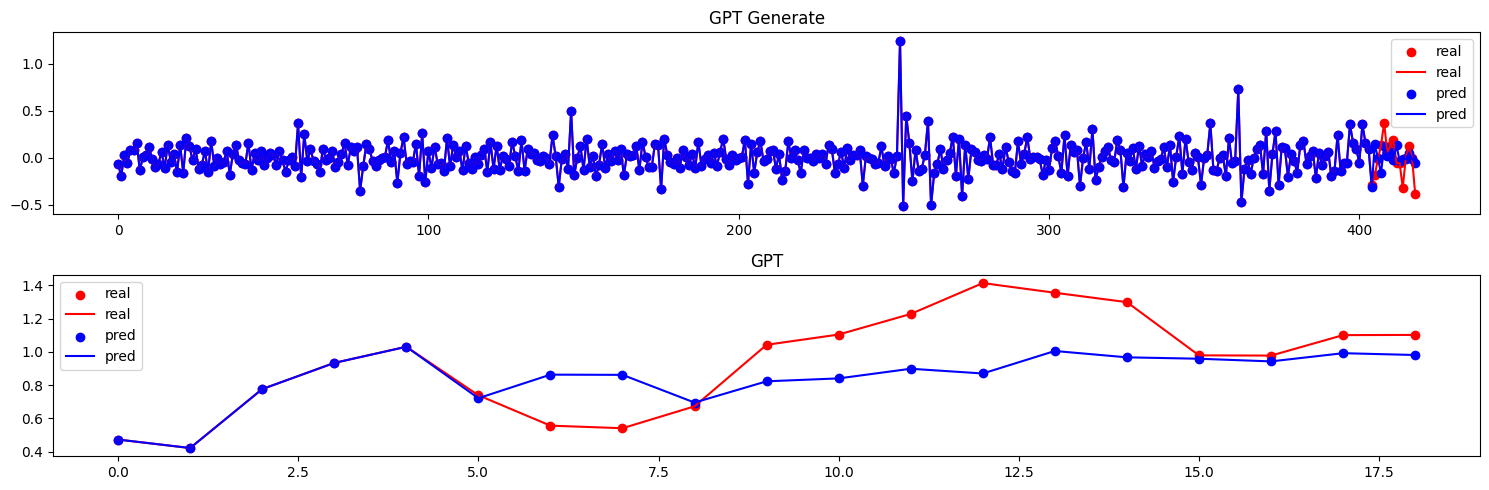

In [95]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



## Run 6


In [96]:

the_range = training_chunk + block_size

index_to_slice = random.randrange(0, length_n - the_range)

index_to_slice

print( for_RNN_data_CIVS.shape[0] )
print( index_to_slice )
print( index_to_slice + the_range )

sliced_chunk_CIVS = for_RNN_data_CIVS[ index_to_slice : index_to_slice + the_range]

n = block_size

print( n )

train_CIVS       = sliced_chunk_CIVS[   : -n ] 
test_CIVS        = sliced_chunk_CIVS[ -n:   ]

chunk300to400_train = train_CIVS[ 300  :  ] 
chunk200to400_train = train_CIVS[ 200  :  ]  
chunk100to400_train = train_CIVS[ 100  :  ] 
chunk000to400_train = train_CIVS[      :  ] 


print( chunk300to400_train.shape )
print( chunk200to400_train.shape )
print( chunk100to400_train.shape )
print( chunk000to400_train.shape )


1383
687
1102
15
(100, 25)
(200, 25)
(300, 25)
(400, 25)


torch.Size([100, 25])
0 train loss =  0.8765842914581299
500 train loss =  0.14320698380470276


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


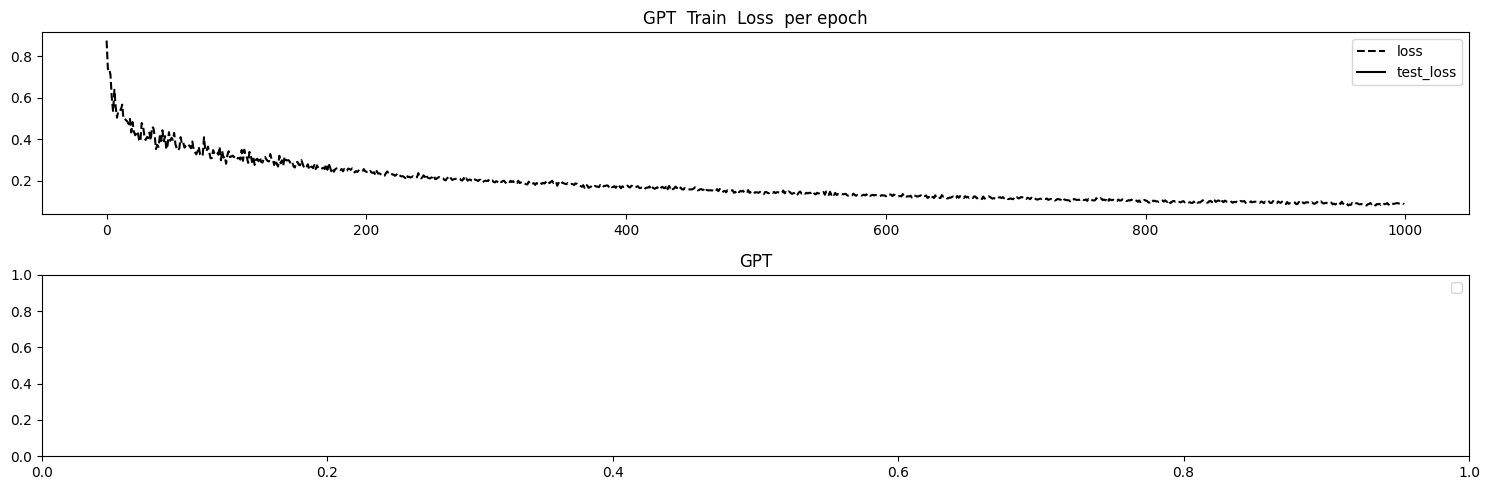

(15, 25)
(100, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

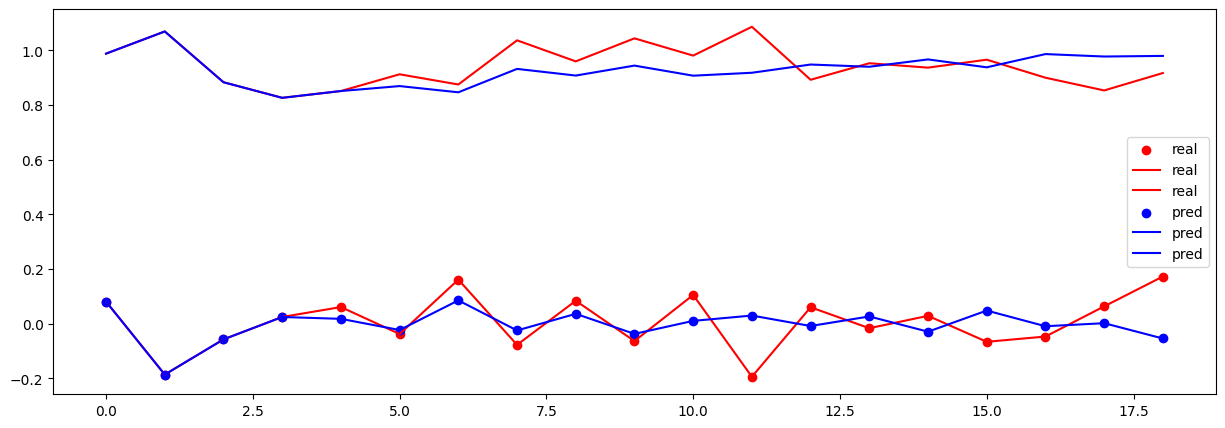

(100, 25)
119
19


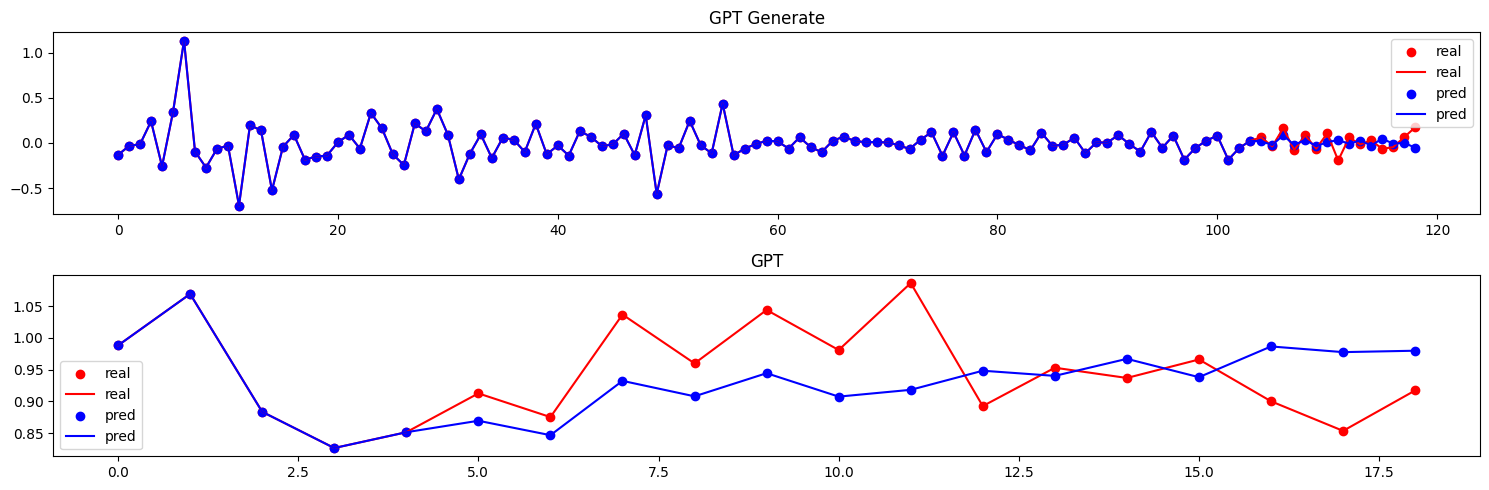

In [97]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk300to400_train )

function_test_rc(  chunk300to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )



torch.Size([200, 25])
0 train loss =  0.8228673338890076
500 train loss =  0.20525528490543365


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


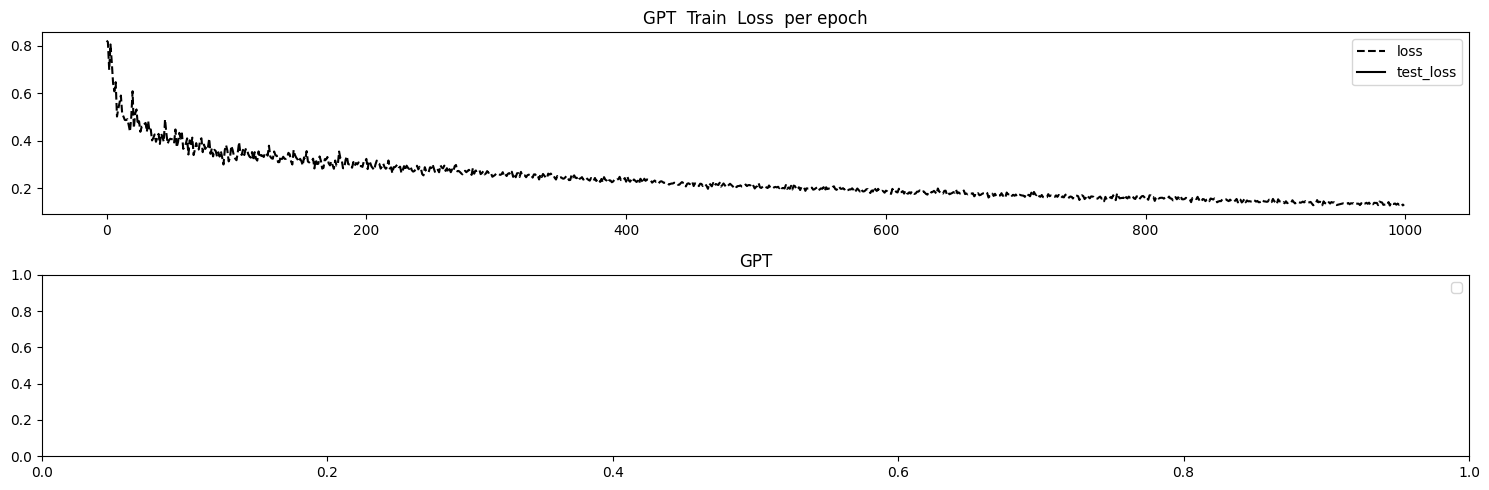

(15, 25)
(200, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

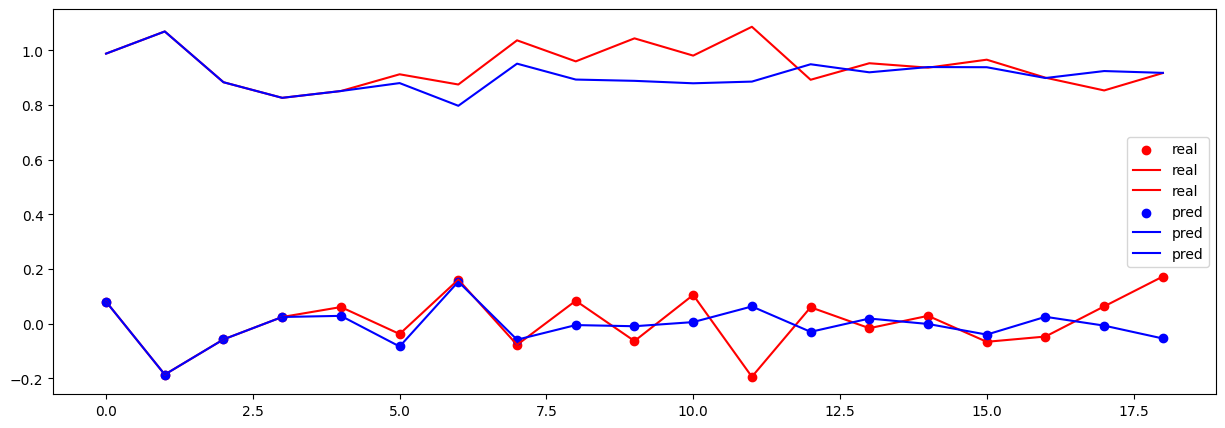

(200, 25)
219
19


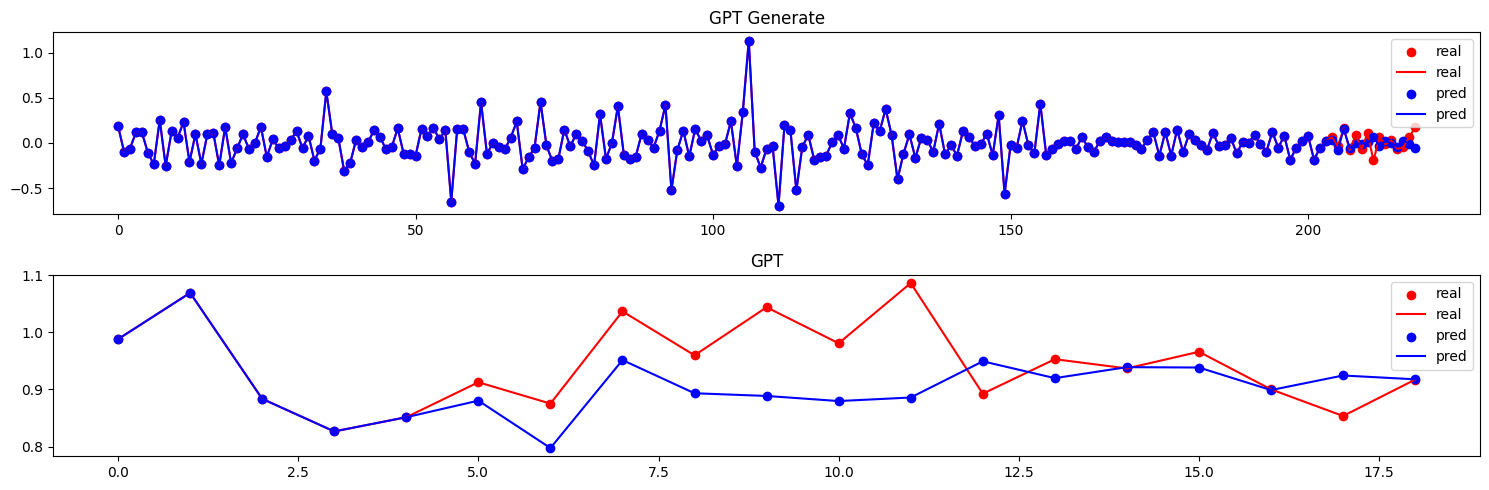

In [98]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk200to400_train )

function_test_rc(  chunk200to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([300, 25])
0 train loss =  0.8226313591003418
500 train loss =  0.243651881814003


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


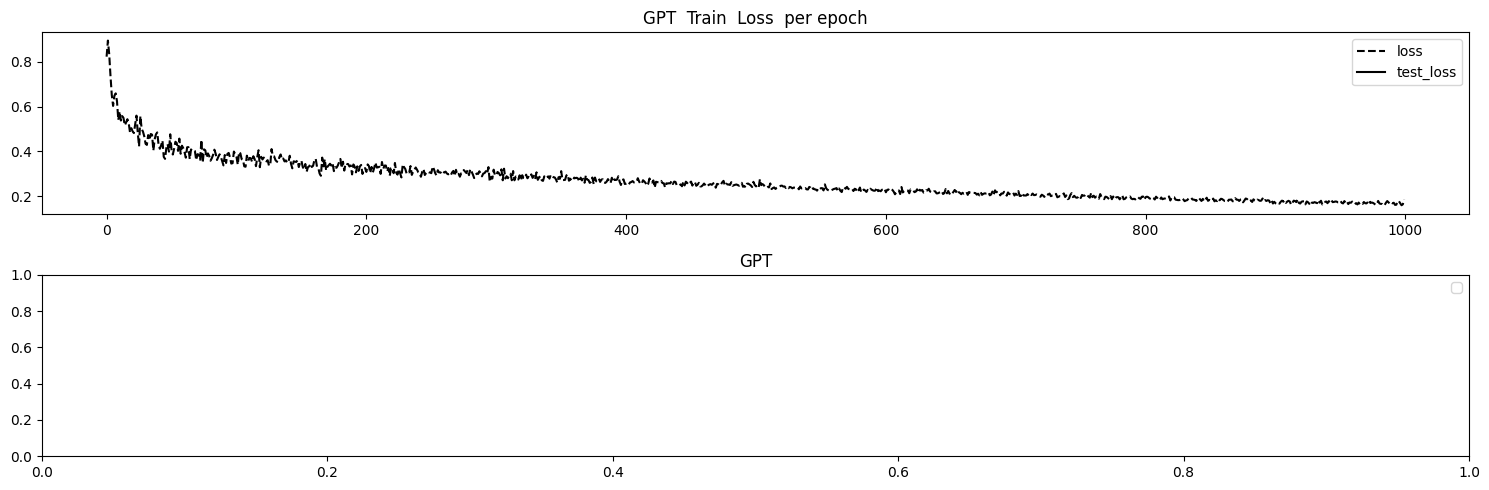

(15, 25)
(300, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

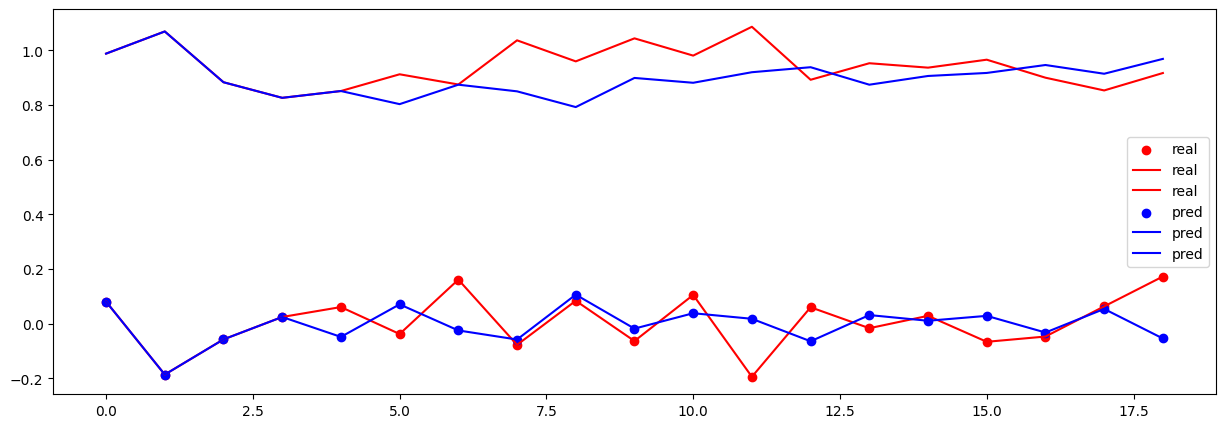

(300, 25)
319
19


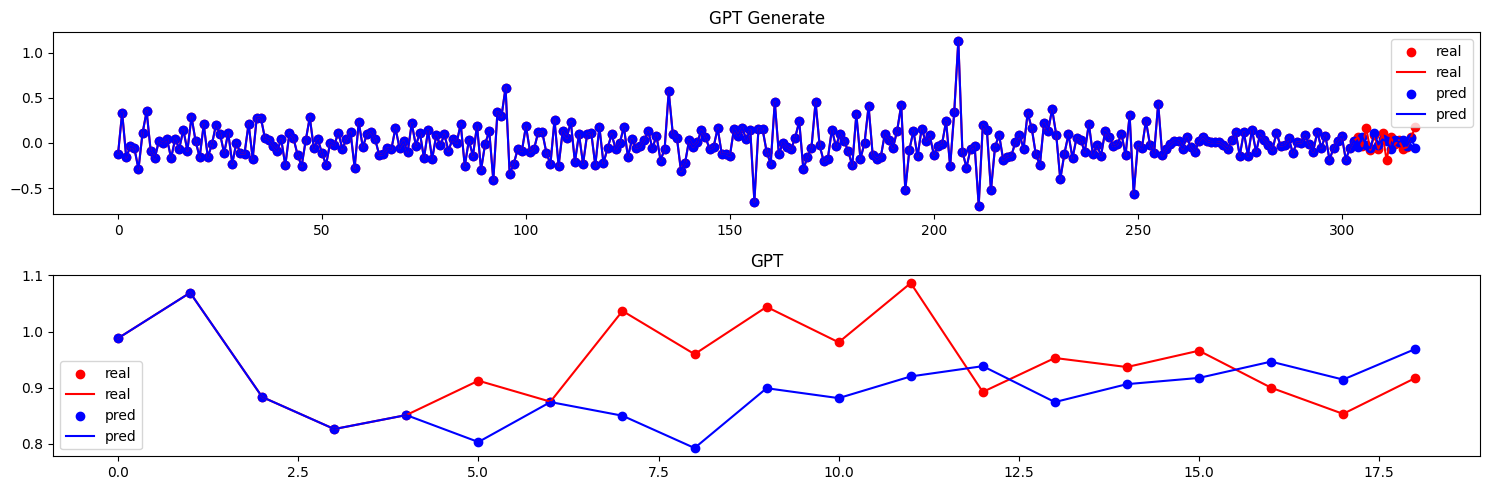

In [99]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk100to400_train  )

function_test_rc(  chunk100to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )


torch.Size([400, 25])
0 train loss =  0.858946681022644
500 train loss =  0.273690402507782


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


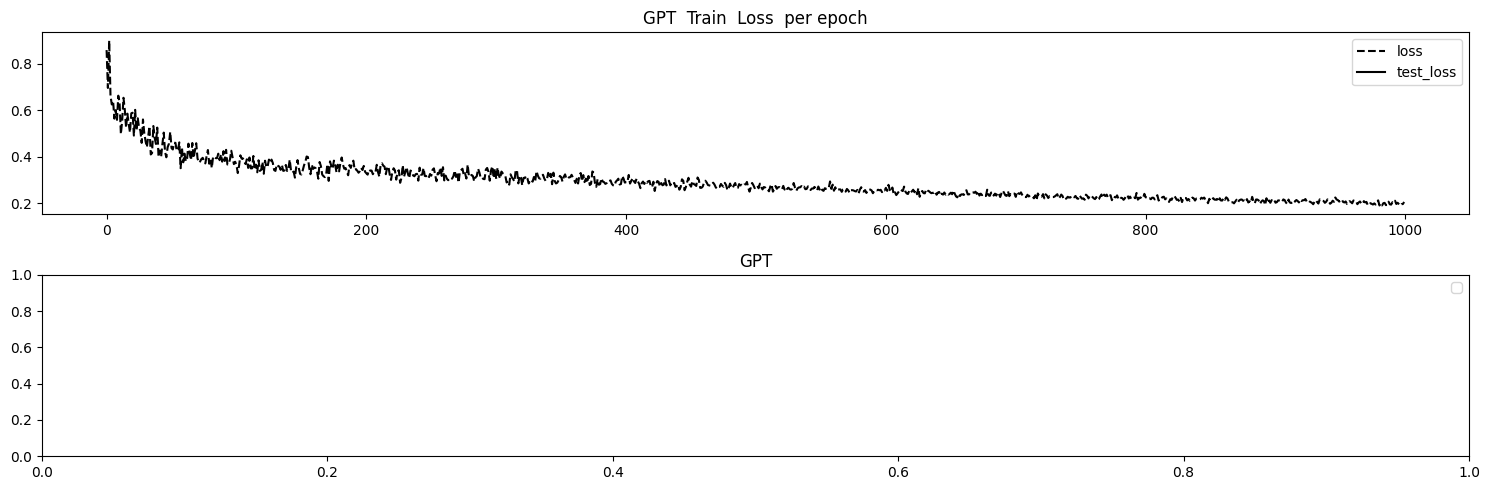

(15, 25)
(400, 25)
(20, 25)
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([20, 25])
torch.Size([1, 19, 25])
torch.Size([1, 19, 25])
input to m.generate
torch.Size([1, 5, 25])
torch.Size([1, 5, 25])
torch.Size([1, 1, 25])
torch.Size([1, 6, 25])
torch.Size([1, 6, 25])
torch.Size([1, 1, 25])
torch.Size([1, 7, 25])
torch.Size([1, 7, 25])
torch.Size([1, 1, 25])
torch.Size([1, 8, 25])
torch.Size([1, 8, 25])
torch.Size([1, 1, 25])
torch.Size([1, 9, 25])
torch.Size([1, 9, 25])
torch.Size([1, 1, 25])
torch.Size([1, 10, 25])
torch.Size([1, 10, 25])
torch.Size([1, 1, 25])
torch.Size([1, 11, 25])
torch.Size([1, 11, 25])
torch.Size([1, 1, 25])
torch.Size([1, 12, 25])
torch.Size([1, 12, 25])
torch.Size([1, 1, 25])
torch.Size([1, 13, 25])
torch.Size([1, 13, 25])
torch.Size([1, 1, 25])
torch.Size([1, 14, 25])
torch.Size([1, 14, 25])
torch.Size([1, 1, 25])
torch.Size([1, 15, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])
torch.Size([1, 16, 25])
torch.Size([1, 15, 25])
torch.Size([1, 1, 25])

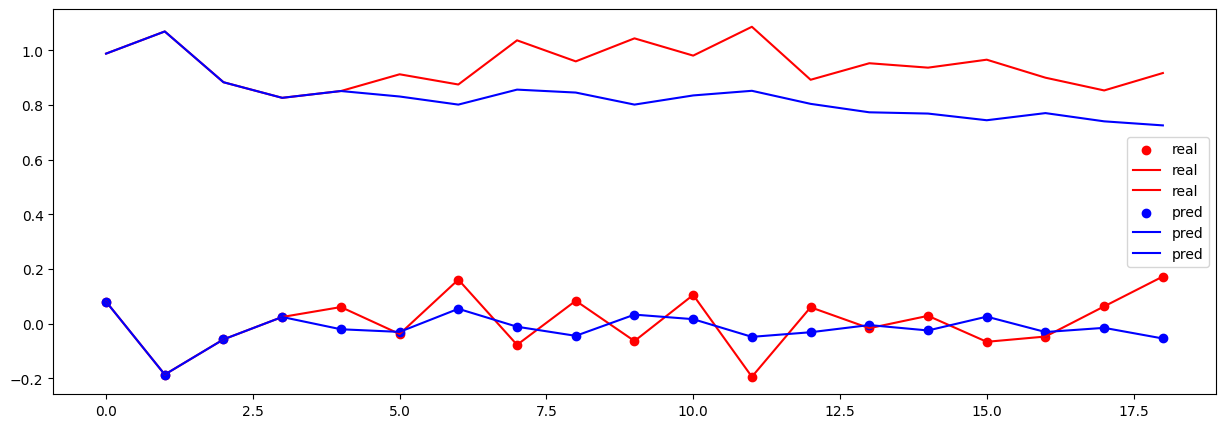

(400, 25)
419
19


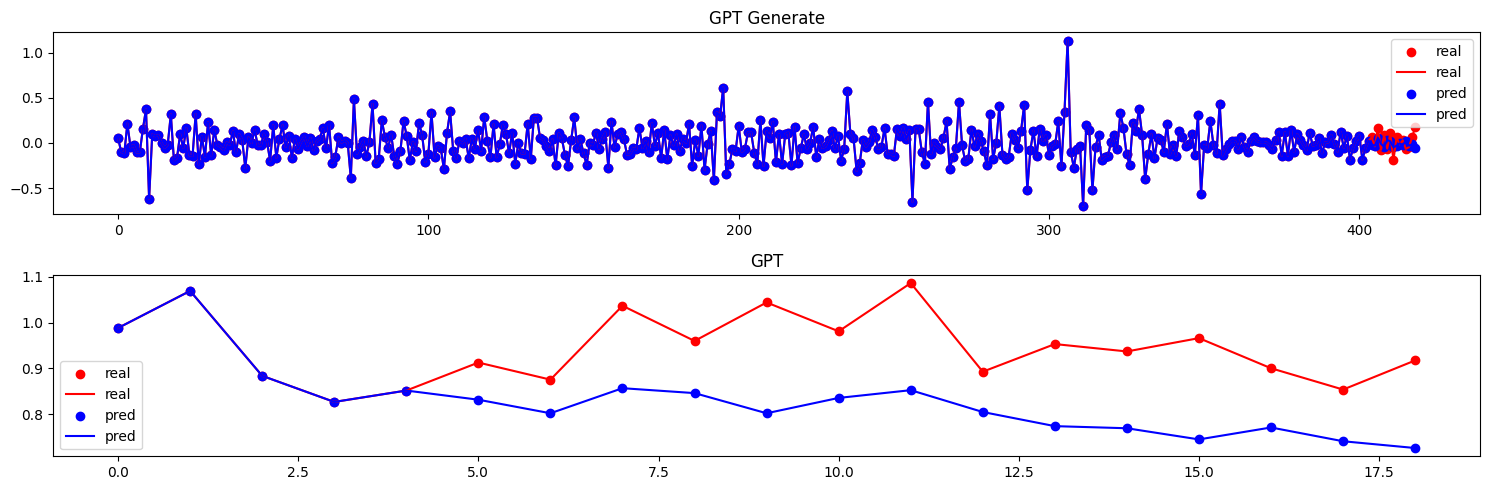

In [100]:

si_GPT, history_GPT, x_means, x_standard_devs  = function_train_rc(  chunk000to400_train )

function_test_rc(  chunk000to400_train, test_CIVS, si_GPT, x_means, x_standard_devs  )
